In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cebra
import cebra.datasets
from cebra import CEBRA


### 1. Load in Mthal data 
- CEBRA models 
- corrisponding embeddings (create from models and neural data)
- discerte_lables (what was used to train the model)
###### Neural Data
- neural_data (all nerual data (100%) full recording), 
- neural_train (neural data seperated into training group (80% of neural_data) that made corresponding cebra model)
- neural_test (neural data seperated into test group (20% of neural_data) that made corresponding cebra model)

In [2]:
mouse = 'necab1'

In [3]:
# variables to load different models and neural data
num_reaches = 179
probe = 'B' # probe used for the neural data
bin_size_in_ms = 50 # in milliseconds
output_dimension = 32 # number of dimensions for the embeddingspre
pre_reach = 0.5
post_reach = 10

load full neural_data

In [4]:
pre_reach_str = str(pre_reach)
if pre_reach < 1:
    window_size = f'{pre_reach_str[0]}{pre_reach_str[-1]}_{post_reach}_timeWindow'
if pre_reach >= 1:
    window_size = f'{pre_reach_str}_{post_reach}_timeWindow'

# the path to the .npy file for the neural data (structred as firing rates x time x neurons)
neural_data_path =f'neural_data/{mouse}_{bin_size_in_ms}ms_FR_{window_size}_{probe}.npy'

# load the neural data
neural_data = cebra.load_data(neural_data_path)
print(neural_data.shape)
neural_data_transposed = neural_data.T  # This changes shape to (58380, 538)
print(neural_data_transposed.shape)
mthal_neural_data = neural_data_transposed
mthal_neural_data_original = neural_data

(403, 38220)
(38220, 403)


load discerte_lables
- discerte_lable Will be the same between Probe A and Probe B
- discerte_lable tells you success and failure per trial, or trial ID

In [5]:
load_path = f'discrete_lables/{mouse}_trial_ID_SF.npy'
discrete_labled_loaded = np.load(load_path)
discete_lables = discrete_labled_loaded
discete_lables.shape
np.unique(discete_lables[:,0]), np.unique(discete_lables[:,1]), discete_lables.shape

(array([0., 1., 2.]), array([0., 1.]), (37590, 2))

Split the Raw neural_data and labels using the split_data function bellow
- will split both into training and test data
- this split was used to train the CEBRA models

In [6]:
def split_data(data, test_ratio):

    split_idx = int(len(data)* (1-test_ratio))
    neural_train = neural_data_transposed[:split_idx]
    neural_test = neural_data_transposed[split_idx:]
    label_train = discete_lables[:split_idx]
    label_test = discete_lables[split_idx:]

    return neural_train, neural_test, label_train, label_test

neural_train, neural_test, label_train, label_test = split_data(neural_data_transposed, 0.2)
neural_train.shape, neural_test.shape, label_train.shape, label_test.shape

((30576, 403), (7644, 403), (30576, 2), (7014, 2))

In [7]:
# path_ = f'train_test_data/{mouse}_neural_train.npy'
# neural_train = np.load(path_)

# path_ = f'train_test_data/{mouse}_neural_test.npy'
# neural_test = np.load(path_)

# path_ = f'train_test_data/{mouse}_label_train.npy'
# label_train = np.load(path_)

# path_ = f'train_test_data/{mouse}_label_test.npy'
# label_test = np.load(path_)

# neural_train.shape, neural_test.shape, label_train.shape, label_test.shape

load cebra models and make embeddings

In [9]:
MI = 5000 # maximum number of iterations
OD =32 # output dimension
P = 'B' # probe letter

In [10]:
# We get train set embedding and test set embedding.
cebra_posdir_model_mthal = cebra.CEBRA.load(f"cebra_models/necab1/01/B/cebra_trialID_SucessFailure_model_{MI}_{OD}_{P}.pt")
cebra_posdir_train_mthal = cebra_posdir_model_mthal.transform(neural_train)
cebra_posdir_test_mthal = cebra_posdir_model_mthal.transform(neural_test)

cebra_pos_model_mthal = cebra.CEBRA.load(f"cebra_models/necab1/01/B/cebra_trialID_model_{MI}_{OD}_{P}.pt")
cebra_pos_train = cebra_pos_model_mthal.transform(neural_train)
cebra_pos_test = cebra_pos_model_mthal.transform(neural_test)

cebra_dir_model_mthal = cebra.CEBRA.load(f"cebra_models/necab1/01/B/cebra_SucessFailure_model_{MI}_{OD}_{P}.pt")
cebra_dir_train_mthal = cebra_dir_model_mthal.transform(neural_train)
cebra_dir_test_mthal = cebra_dir_model_mthal.transform(neural_test)

cebra_pos_all_mthal = cebra_pos_model_mthal.transform(neural_data_transposed)
cebra_dir_all_mthal = cebra_dir_model_mthal.transform(neural_data_transposed)
cebra_posdir_all_mthal = cebra_posdir_model_mthal.transform(neural_data_transposed)


preview Motor Thalamic embeddings

In [11]:
cebra_posdir_all_mthal = cebra_posdir_all_mthal[:37590]
cebra_posdir_all_mthal.shape

# cebra_time_test_chopped = cebra_time_test[:7014]
# cebra_time_test_chopped.shape

(37590, 32)

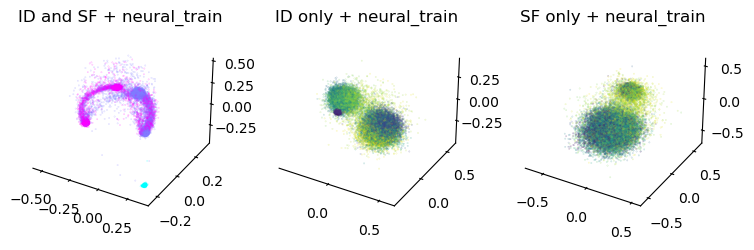

In [15]:
fig=plt.figure(figsize=(9,6))

ax1=plt.subplot(231, projection = '3d')
ax2=plt.subplot(232, projection = '3d')
ax3=plt.subplot(233, projection = '3d')


ax1=cebra.plot_embedding(ax=ax1, embedding=cebra_posdir_all_mthal, embedding_labels=discete_lables[:,0], title='ID and SF + neural_train')
ax2=cebra.plot_embedding(ax=ax2, embedding=cebra_pos_all_mthal, embedding_labels='time', title='ID only + neural_train')
ax3=cebra.plot_embedding(ax=ax3, embedding=cebra_dir_all_mthal, embedding_labels='time', title='SF only + neural_train')


# ax2=cebra.plot_embedding(ax=ax2, embedding=cebra_pos_all, embedding_labels=label_train[:,0], title='ID only + all neural_data')

plt.show()


load cebra-time models (not trained with lables)

In [16]:
path_0 = "necab1_50msFr_0.0003LR_2000MI_outDim8_B_2024-04-04_14-35-46_timeOnly.cebra"

cebra_time_model_mthal = cebra.CEBRA.load(f'time_only_models/{path_0}')
cebra_time_all_mthal = cebra_time_model_mthal.transform(neural_data_transposed)
cebra_time_train_mthal = cebra_time_model_mthal.transform(neural_train)
cebra_time_test_mthal = cebra_time_model_mthal.transform(neural_test)


Chop this cebra models into the correct size
- this is because their are 3 less reachs in the labels compared to the nerual data
- so you have to chop the last three reachs off the model

In [17]:
cebra_time_all_mthal = cebra_time_all_mthal[:37590]
cebra_time_all_mthal.shape

cebra_time_test_mthal = cebra_time_test_mthal[:7014]
cebra_time_test_mthal.shape

(7014, 8)

Text(0.5, 0.98, 'CEBRA-Time Model, Mthal')

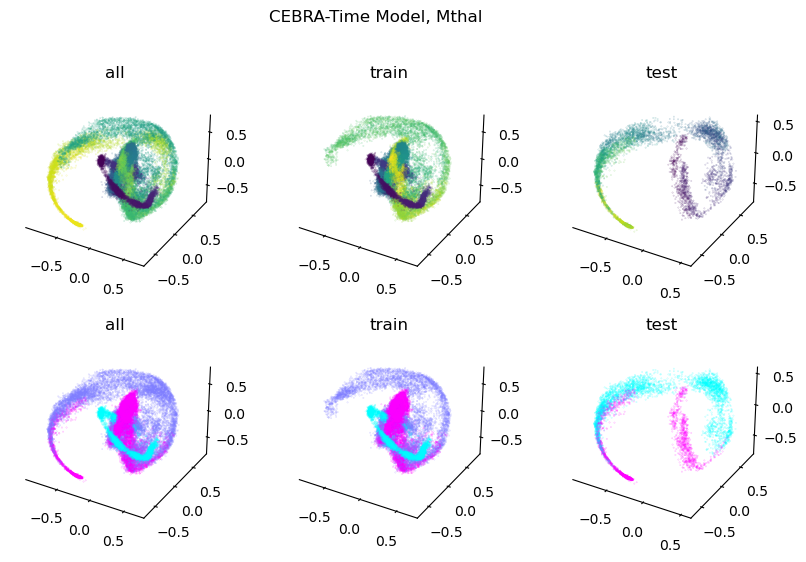

In [18]:

plt.figure(figsize=(10, 6))
#  Creating each subplot in the 5x2 grid
ax1 = plt.subplot(231, projection='3d')  # First row, first column
ax2 = plt.subplot(232, projection='3d')  # First row, second column
ax3 = plt.subplot(233, projection='3d')  # First row, second column
ax4 = plt.subplot(234, projection='3d')  # First row, second column
ax5 = plt.subplot(235, projection='3d')  # First row, second column
ax6 = plt.subplot(236, projection='3d')  # First row, second column


ax1 = cebra.plot_embedding(ax=ax1,embedding=cebra_time_all_mthal, embedding_labels='time', title='all')
ax2 = cebra.plot_embedding(ax=ax2,embedding=cebra_time_train_mthal, embedding_labels='time', title='train')
ax3 = cebra.plot_embedding(ax=ax3,embedding=cebra_time_test_mthal, embedding_labels='time', title='test')
ax4 = cebra.plot_embedding(ax=ax4,embedding=cebra_time_all_mthal, embedding_labels=discete_lables[:,0], title='all')
ax5 = cebra.plot_embedding(ax=ax5,embedding=cebra_time_train_mthal, embedding_labels=label_train[:,0], title='train')
ax6 = cebra.plot_embedding(ax=ax6,embedding=cebra_time_test_mthal, embedding_labels=label_test[:,0], title='test')
# add title
plt.suptitle('CEBRA-Time Model, Mthal')

Set what embeddings you want to use for training the RNN
- can set (mthal_embedding_train) to be embeddings made from cebra-time 
- or your can set (mthal_embedding_train) to be embeddings made from cebra-behavior, these were made with lables 

In [19]:
mthal_embedding_train = cebra_posdir_train_mthal
mthal_embedding_all = cebra_posdir_all_mthal

### 1.2 Load in M1 data 


In [20]:
probe = 'A' # probe used for the neural data
P = probe

load full neural data

In [21]:
pre_reach_str = str(pre_reach)
if pre_reach < 1:
    window_size = f'{pre_reach_str[0]}{pre_reach_str[-1]}_{post_reach}_timeWindow'
if pre_reach >= 1:
    window_size = f'{pre_reach_str}_{post_reach}_timeWindow'

# the path to the .npy file for the neural data (structred as firing rates x time x neurons)
neural_data_path =f'neural_data/{mouse}_{bin_size_in_ms}ms_FR_{window_size}_{probe}.npy'

# load the neural data
neural_data = cebra.load_data(neural_data_path)
print(neural_data.shape)
neural_data_transposed = neural_data.T  # This changes shape to (58380, 538)
print(neural_data_transposed.shape)
m1_neural_data = neural_data_transposed
m1_neural_data_orignal = neural_data

(12, 38220)
(38220, 12)


Split the full neural data sets into training and test sets
- this will split the data the same way that it was split for the cebra behavior training

In [22]:
def split_data(data, test_ratio):

    split_idx = int(len(data)* (1-test_ratio))
    neural_train = neural_data_transposed[:split_idx]
    neural_test = neural_data_transposed[split_idx:]
    label_train = discete_lables[:split_idx]
    label_test = discete_lables[split_idx:]

    return neural_train, neural_test, label_train, label_test

neural_train, neural_test, label_train, label_test = split_data(neural_data_transposed, 0.2)
neural_train.shape, neural_test.shape, label_train.shape, label_test.shape

((30576, 12), (7644, 12), (30576, 2), (7014, 2))

load cebra models and make embeddings

In [23]:
MI = 5000 # maximum number of iterations
OD =32 # output dimension
P = 'A' # probe letter

In [24]:
np.unique(label_train[:,0]), np.unique(label_train[:,1])

(array([0., 1., 2.]), array([0., 1.]))

In [25]:
MI  = 1000
OD = 32
P = "A"

In [26]:
# We get train set embedding and test set embedding.
cebra_posdir_model_m1 = cebra.CEBRA.load(f"cebra_models/necab1/01/A/cebra_trialID_SucessFailure_model_{MI}_{OD}_{P}.pt")
cebra_posdir_train_m1 = cebra_posdir_model_m1.transform(neural_train)
cebra_posdir_test_m1 = cebra_posdir_model_m1.transform(neural_test)

cebra_pos_model_m1 = cebra.CEBRA.load(f"cebra_models/necab1/01/A/cebra_trialID_model_{MI}_{OD}_{P}.pt")
cebra_pos_train_m1 = cebra_pos_model_m1.transform(neural_train)
cebra_pos_test_m1 = cebra_pos_model_m1.transform(neural_test)

cebra_dir_model_m1  = cebra.CEBRA.load(f"cebra_models/necab1/01/A/cebra_SucessFailure_model_{MI}_{OD}_{P}.pt")
cebra_dir_train_m1 = cebra_dir_model_m1.transform(neural_train)
cebra_dir_test_m1 = cebra_dir_model_m1.transform(neural_test)

cebra_pos_all_m1 = cebra_pos_model_m1.transform(neural_data_transposed)
cebra_dir_all_m1 = cebra_dir_model_m1.transform(neural_data_transposed)
cebra_posdir_all_m1 = cebra_posdir_model_m1.transform(neural_data_transposed)

In [27]:
cebra_posdir_all_m1.shape

(38220, 32)

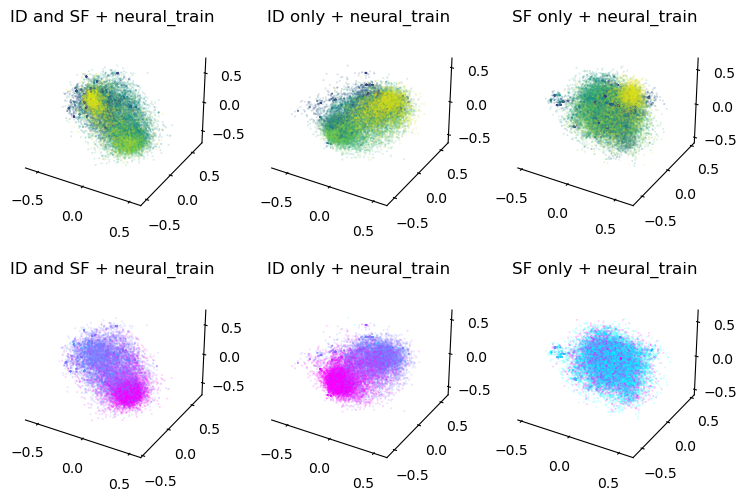

In [28]:
fig=plt.figure(figsize=(9,6))

ax1=plt.subplot(231, projection = '3d')
ax2=plt.subplot(232, projection = '3d')
ax3=plt.subplot(233, projection = '3d')

ax4=plt.subplot(234, projection = '3d')
ax5=plt.subplot(235, projection = '3d')
ax6=plt.subplot(236, projection = '3d')


ax1=cebra.plot_embedding(ax=ax1, embedding=cebra_posdir_all_m1, embedding_labels='time', title='ID and SF + neural_train')
ax2=cebra.plot_embedding(ax=ax2, embedding=cebra_pos_all_m1, embedding_labels='time', title='ID only + neural_train')
ax3=cebra.plot_embedding(ax=ax3, embedding=cebra_dir_all_m1, embedding_labels='time', title='SF only + neural_train')

ax4=cebra.plot_embedding(ax=ax4, embedding=cebra_posdir_train_m1, embedding_labels=label_train[:,0], title='ID and SF + neural_train')
ax5=cebra.plot_embedding(ax=ax5, embedding=cebra_pos_train_m1, embedding_labels=label_train[:,0], title='ID only + neural_train')
ax6=cebra.plot_embedding(ax=ax6, embedding=cebra_dir_train_m1, embedding_labels=label_train[:,1], title='SF only + neural_train')



# ax2=cebra.plot_embedding(ax=ax2, embedding=cebra_pos_all, embedding_labels=label_train[:,0], title='ID only + all neural_data')

plt.show()


Load cebra-time models and make embeddings

In [29]:
path_0 = 'necab1_50msFr_0.001LR_1500MI_outDim20_A_2024-04-01_18-57-17_timeOnly.cebra'

cebra_time_model_m1 = cebra.CEBRA.load(f'time_only_models/{path_0}')
cebra_time_all_m1 = cebra_time_model_m1.transform(neural_data_transposed)
cebra_time_train_m1 = cebra_time_model_m1.transform(neural_train)
cebra_time_test_m1 = cebra_time_model_m1.transform(neural_test)

In [30]:
cebra_time_all_m1 = cebra_time_all_m1[:37590]
cebra_posdir_all_m1 = cebra_posdir_all_m1[:37590]


cebra_time_test_m1 = cebra_time_test_m1[:7014]
cebra_time_test_m1.shape

(7014, 20)

Text(0.5, 0.98, 'CEBRA-Time Model, M1')

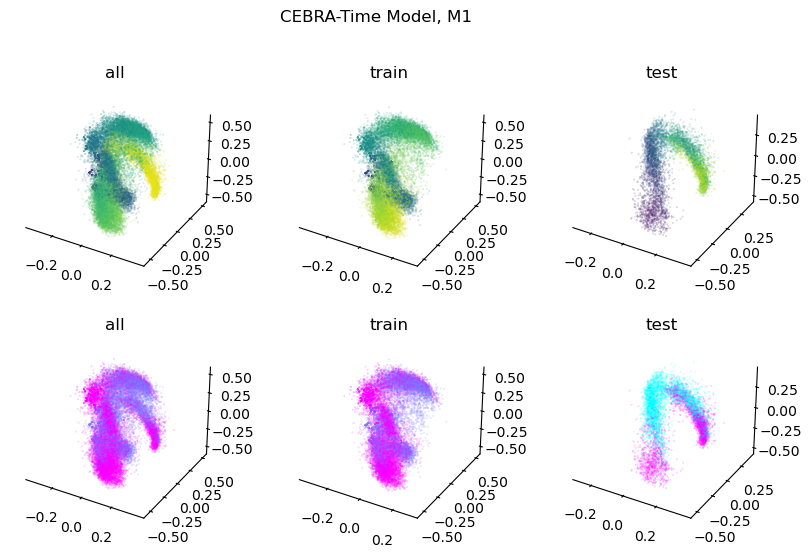

In [31]:


plt.figure(figsize=(10, 6))
#  Creating each subplot in the 5x2 grid
ax1 = plt.subplot(231, projection='3d')  # First row, first column
ax2 = plt.subplot(232, projection='3d')  # First row, second column
ax3 = plt.subplot(233, projection='3d')  # First row, second column
ax4 = plt.subplot(234, projection='3d')  # First row, second column
ax5 = plt.subplot(235, projection='3d')  # First row, second column
ax6 = plt.subplot(236, projection='3d')  # First row, second column


ax1 = cebra.plot_embedding(ax=ax1,embedding=cebra_time_all_m1, embedding_labels='time', title='all')
ax2 = cebra.plot_embedding(ax=ax2,embedding=cebra_time_train_m1, embedding_labels='time', title='train')
ax3 = cebra.plot_embedding(ax=ax3,embedding=cebra_time_test_m1, embedding_labels='time', title='test')
ax4 = cebra.plot_embedding(ax=ax4,embedding=cebra_time_all_m1, embedding_labels=discete_lables[:,0], title='all')
ax5 = cebra.plot_embedding(ax=ax5,embedding=cebra_time_train_m1, embedding_labels=label_train[:,0], title='train')
ax6 = cebra.plot_embedding(ax=ax6,embedding=cebra_time_test_m1, embedding_labels=label_test[:,0], title='test')

# add title
plt.suptitle('CEBRA-Time Model, M1')

Set what embeddings you want to use for training the RNN
- can set (m1_embedding_train) to be embeddings made from cebra-time 
- or your can set (m1_embedding_train) to be embeddings made from cebra-behavior, these were made with lables 

In [32]:
# set mthal embeddings for rnn input
mthal_embedding_train = cebra_posdir_train_mthal
mthal_embedding_all = cebra_posdir_all_mthal

# set m1 embeddings for rnn target
m1_embedding_train = cebra_posdir_train_m1
m1_embedding_all = cebra_posdir_all_m1



Double check what you using to train the rnn

In [33]:
mthal_embedding_all.shape, mthal_embedding_train.shape, m1_embedding_all.shape, m1_embedding_train.shape

((37590, 32), (30576, 32), (37590, 32), (30576, 32))

In [40]:
np.unique(discete_lables[:,1])

array([0., 1.])

Text(0.5, 0.98, 'checking embeddings used to train')

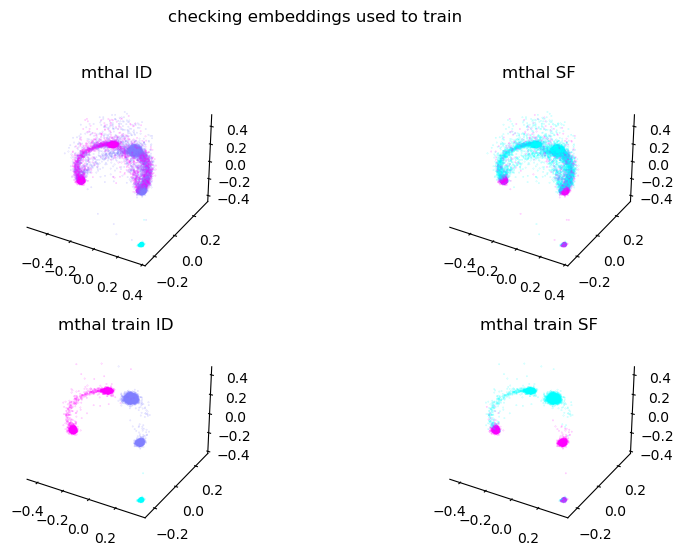

In [39]:


plt.figure(figsize=(10, 6))
#  Creating each subplot in the 5x2 grid
ax1 = plt.subplot(221, projection='3d')  # First row, first column
ax2 = plt.subplot(222, projection='3d')  # First row, second column
ax3 = plt.subplot(223, projection='3d')  # First row, second column
ax4 = plt.subplot(224, projection='3d')  # First row, second column


ax1 = cebra.plot_embedding(ax=ax1,embedding=mthal_embedding_all, embedding_labels=discete_lables[:,0], title='mthal ID')
ax2 = cebra.plot_embedding(ax=ax2,embedding=mthal_embedding_all, embedding_labels=discete_lables[:,1], title='mthal SF')

ax3 = cebra.plot_embedding(ax=ax3,embedding=mthal_embedding_train, embedding_labels=label_train[:,0], title='mthal train ID')
ax4 = cebra.plot_embedding(ax=ax4,embedding=mthal_embedding_train, embedding_labels=label_train[:,1], title='mthal train SF')


ax5 = cebra.plot_embedding(ax=ax5,embedding=m1_embedding_all, embedding_labels=discete_lables[:,1], title='m1')
ax5 = cebra.plot_embedding(ax=ax5,embedding=m1_embedding_train, embedding_labels=label_train[:,0], title='m1')

# add title
plt.suptitle('checking embeddings used to train')

### 4. Convert Data into correctly shapped df

Turning neural_data and embedding data into to a df that is time bins by units for neural data. Or timebins by embeddings for embedding data
- you need each row to be a single time bin
- each column is a unit. 


In [161]:
mthal_neural_data_original

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 20., 20., 20.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [20.,  0., 40., ...,  0., 20.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 20.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [164]:
# Conver neural data into a df that is (bins , features) = (units, timebins)
data_mthal_neuralData_T = mthal_neural_data_original.T
data_mthal_neuralData = pd.DataFrame(data_mthal_neuralData_T)
data_mthal_neuralData = data_mthal_neuralData.ffill()
print(data_mthal_neuralData.shape)
data_mthal_neuralData.head(2)

(38220, 403)


0    1    2    3    4     5    6    7    8    9    ...  393  394  395  396  \
0  0.0  0.0  0.0  0.0  0.0  20.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

    397  398  399   400  401  402  
0  20.0  0.0  0.0  20.0  0.0  0.0  
1   0.0  0.0  0.0   0.0  0.0  0.0  

[2 rows x 403 columns]

In [165]:
# Conver neural data into a df that is (bins , features) = (units, timebins)\
data_m1_neuralData_T = m1_neural_data_orignal.T
data_m1_neuralData = pd.DataFrame(data_m1_neuralData_T)
data_m1_neuralData = data_m1_neuralData.ffill()
print(data_m1_neuralData.shape)
data_m1_neuralData.head(2)

(38220, 12)


0    1    2    3    4    5    6    7    8    9    10   11
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

embeddings

In [166]:
# set mthal embeddings for rnn input
mthal_embedding_train = cebra_posdir_train_mthal
mthal_embedding_all = cebra_posdir_all_mthal

# set m1 embeddings for rnn target
m1_embedding_train = cebra_posdir_train_m1
m1_embedding_all = cebra_posdir_all_m1


In [167]:
# Conver neural embeddings into a df that is (bins , features) = (units, embeddings)
data_m1_embedding_T = m1_embedding_all
data_m1_embedding = pd.DataFrame(data_m1_embedding_T)
data_m1_embedding = data_m1_embedding.ffill()
print(data_m1_embedding.shape)
data_m1_embedding.head(2)

(37590, 32)


0         1         2         3         4         5         6   \
0 -0.205585 -0.008578  0.386084  0.273588 -0.039456  0.320059 -0.261363   
1 -0.205585 -0.008578  0.386084  0.273588 -0.039456  0.320059 -0.261363   

         7         8         9   ...        22        23        24       25  \
0  0.043261 -0.061703 -0.112203  ...  0.235667  0.077723  0.171407  0.05487   
1  0.043261 -0.061703 -0.112203  ...  0.235667  0.077723  0.171407  0.05487   

         26        27        28        29        30        31  
0  0.114489  0.087127  0.097014 -0.228302  0.170024  0.039335  
1  0.114489  0.087127  0.097014 -0.228302  0.170024  0.039335  

[2 rows x 32 columns]

In [168]:
# Conver neural embeddings into a df that is (bins , features) = (units, embeddings)
data_mthal_embedding_T = mthal_embedding_all
data_mthal_embedding = pd.DataFrame(data_mthal_embedding_T)
data_mthal_embedding = data_mthal_embedding.ffill()
print(data_mthal_embedding.shape)
data_mthal_embedding.head(2)

(37590, 32)


0         1         2         3         4         5         6   \
0  0.340772 -0.227974 -0.342491 -0.050870  0.001971  0.028572 -0.223870   
1  0.338078 -0.230757 -0.341012 -0.044758  0.002957  0.029362 -0.226705   

         7         8         9   ...        22        23        24        25  \
0 -0.181358 -0.104856 -0.184973  ... -0.142214 -0.065764  0.126317 -0.099972   
1 -0.182065 -0.105827 -0.187399  ... -0.144694 -0.068304  0.126885 -0.098617   

         26        27        28        29        30        31  
0 -0.071244 -0.134367  0.211022  0.162007 -0.096729 -0.062965  
1 -0.070163 -0.136135  0.207083  0.156941 -0.097587 -0.065613  

[2 rows x 32 columns]

<Axes3D: title={'center': 'ID only + neural_train'}>

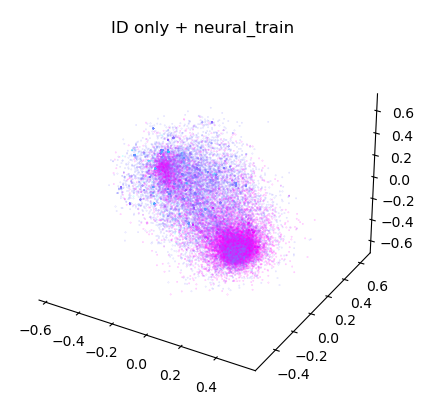

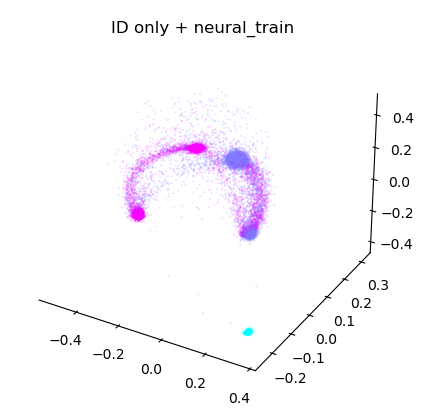

In [181]:
data_m1_embedding_T
cebra.plot_embedding(embedding=data_m1_embedding.to_numpy(), embedding_labels=discete_lables[:,0], title='ID only + neural_train')
cebra.plot_embedding(embedding=data_mthal_embedding.to_numpy(), embedding_labels=discete_lables[:,0], title='ID only + neural_train')

Covert which dataframes you want into data, so it can be fit into rest of code

In [182]:
# data = data_m1_neuralData
# data = data_mthal_neuralData
# data = data_mthal_embedding
# data = data_m1_embedding

In [230]:
    # Assuming data_mthal_neuralData_T and data_mthal_embedding_T are correctly set up
reaches_to_view = range(0, 30)  # Range of reaches to display

for reach in reaches_to_view:
    # Calculate the start and end indices for each reach
    reach_start = reach * 210
    reach_end = reach_start + 210


    embedding_1 = data_mthal_embedding[0].to_numpy()[reach_start:reach_end]
    plt.plot(embedding_1)

IndentationError: expected an indented block (1677684269.py, line 6)

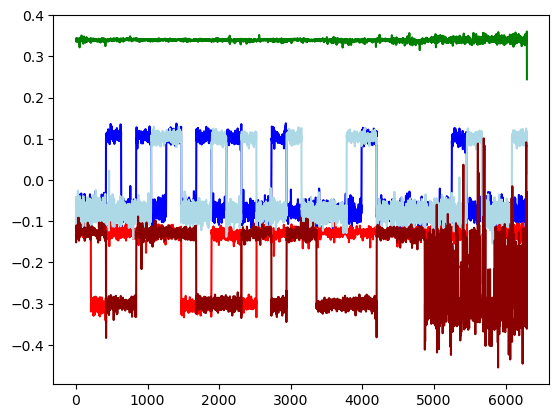

In [246]:

embedding_1 = data_mthal_embedding[0].to_numpy()[0:6300] #base
embedding_2 = data_mthal_embedding[0].to_numpy()[6300:12600] # pert1
embedding_3 = data_mthal_embedding[0].to_numpy()[12600:18900] # wash1
embedding_4 = data_mthal_embedding[0].to_numpy()[18900:25200] # pert2
embedding_5 = data_mthal_embedding[0].to_numpy()[25200:31500] # wash2




plt.plot(embedding_1,color='green')
plt.plot(embedding_2,color='blue')
plt.plot(embedding_3,color='red')
plt.plot(embedding_4,color='lightblue')
plt.plot(embedding_5,color='darkred')


In [ ]:
embedding_1 = data_mthal_embedding[0].to_numpy()[0:6300] #base
embedding_2 = data_mthal_embedding[0].to_numpy()[6300:12600] # pert1
embedding_3 = data_mthal_embedding[0].to_numpy()[12600:18900] # wash1
embedding_4 = data_mthal_embedding[0].to_numpy()[18900:25200] # pert2
embedding_5 = data_mthal_embedding[0].to_numpy()[25200:31500] # wash2




plt.plot(embedding_1,color='green')
plt.plot(embedding_2,color='blue')
plt.plot(embedding_3,color='red')
plt.plot(embedding_4,color='lightblue')
plt.plot(embedding_5,color='darkred')

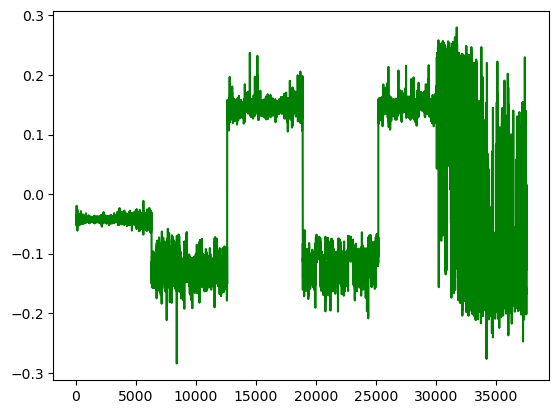

In [250]:
embedding_1 = data_mthal_embedding[3].to_numpy()[0:37590] #base
# embedding_2 = data_mthal_embedding[1].to_numpy()[0:37590] # pert1
# embedding_3 = data_mthal_embedding[2].to_numpy()[0:37590] # wash1
# embedding_4 = data_mthal_embedding[0].to_numpy()[18900:25200] # pert2
# embedding_5 = data_mthal_embedding[0].to_numpy()[25200:31500] # wash3



plt.plot(embedding_1,color='green')
# plt.plot(embedding_2,color='blue')
# plt.plot(embedding_3,color='red')


check embeddings and FR of M1 and Mthal

In [207]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

def view_units(unit_to_view,second_unit_to_view,third_unit_to_view,reaches_to_view):

    # Close any previous plots
    plt.close('all')

    # Create a new figure with a specific size
    fig = plt.figure(figsize=(15, 14))

    # First row
    ax1 = fig.add_subplot(431)  # First row, first column
    ax2 = fig.add_subplot(432)  # First row, second column
    ax3 = fig.add_subplot(433)  # First row, third column

    # Second row
    ax4 = fig.add_subplot(434)  # Second row, first column
    ax5 = fig.add_subplot(435)  # Second row, second column
    ax6 = fig.add_subplot(436)  # Second row, third column

    # Third row
    ax7 = fig.add_subplot(437)  # Third row, first column
    ax8 = fig.add_subplot(438)  # Third row, second column
    ax9 = fig.add_subplot(439)  # Third row, third column

    # Fourth row
    ax10 = fig.add_subplot(4, 3, 10,projection='3d')  # Fourth row, first column
    ax11 = fig.add_subplot(4, 3, 11,projection='3d')  # Fourth row, second column
    ax12 = fig.add_subplot(4, 3, 12, projection='3d')  # Fourth row, third column

 
    # Assuming data_mthal_neuralData_T and data_mthal_embedding_T are correctly set up
    for reach in reaches_to_view:
        # Calculate the start and end indices for each reach
        reach_start = reach * 210
        reach_end = reach_start + 210

        # Fetch data for the specified reach
        unit_frs = data_mthal_neuralData[unit_to_view].to_numpy()[reach_start:reach_end]
        second_unit_frs = data_mthal_neuralData[second_unit_to_view].to_numpy()[reach_start:reach_end]
        third_unit_frs = data_mthal_neuralData[third_unit_to_view].to_numpy()[reach_start:reach_end]


        unit_embedding = data_mthal_embedding[0].to_numpy()[reach_start:reach_end]
        second_unit_embedding = data_mthal_embedding[1].to_numpy()[reach_start:reach_end]
        third_unit_embedding = data_mthal_embedding[2].to_numpy()[reach_start:reach_end]


        embedding_1 = data_mthal_embedding[0].to_numpy()[reach_start:reach_end]
        embedding_2 = data_mthal_embedding[1].to_numpy()[reach_start:reach_end]
        embedding_3 = data_mthal_embedding[2].to_numpy()[reach_start:reach_end]

        
        embedding_1_m1 = data_m1_embedding[0].to_numpy()[reach_start:reach_end]
        embedding_2_m1 = data_m1_embedding[1].to_numpy()[reach_start:reach_end]
        embedding_3_m1 = data_m1_embedding[2].to_numpy()[reach_start:reach_end]

        # Plotting data for the specified reach, first unit
        ax1.plot(unit_frs, label=f'Reach {reach}')
        ax2.plot(second_unit_frs, label=f'Reach {reach}')
        ax3.plot(third_unit_frs, label=f'Reach {reach}')

        # Plotting data for the specified reach, second unit
        ax4.plot(embedding_1, label=f'Reach {reach}')
        ax5.plot(embedding_2, label=f'Reach {reach}')
        ax6.plot(embedding_3,  label=f'Reach {reach}')

        
        # Plotting data for the specified reach, second unit
        ax7.plot(embedding_1_m1, label=f'Reach {reach}')
        ax8.plot(embedding_2_m1, label=f'Reach {reach}')
        ax9.plot(embedding_3_m1,  label=f'Reach {reach}')

        ax10.plot(embedding_1, embedding_2, embedding_3, label=f'Reach {reach}')
        ax11.plot(embedding_1_m1, embedding_2_m1, embedding_3_m1, label=f'Reach {reach}')



    # Adding legends to each subplot
    # for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    #     ax.legend()
    # Setting titles for subplots, first unit
    ax1.set_title(f"Mtahl Unit {unit_to_view} Firing Rate")
    ax2.set_title(f"Mtahl Unit {second_unit_to_view} Firing Rate")
    ax3.set_title(f"Mtahl Unit {third_unit_to_view} Firing Rate")

    # Setting titles for subplots, second unit
    ax4.set_title("Mtahl First Embedding")
    ax5.set_title("Mtahl Second Embedding")
    ax6.set_title("Mtahl Third Embedding")

    ax7.set_title("M1 First Embedding")
    ax8.set_title("M1 Second Embedding")
    ax9.set_title("M1 Third Embedding")

    ax10.set_title("Mthal 3D Embedding")
    ax11.set_title("M1 3D Embedding")



    # Overall title for the figure
    fig.suptitle(f'Checking top 3 embeddings for M1 and Mthal at spefici reachs')

    # Show the plot
    plt.show()


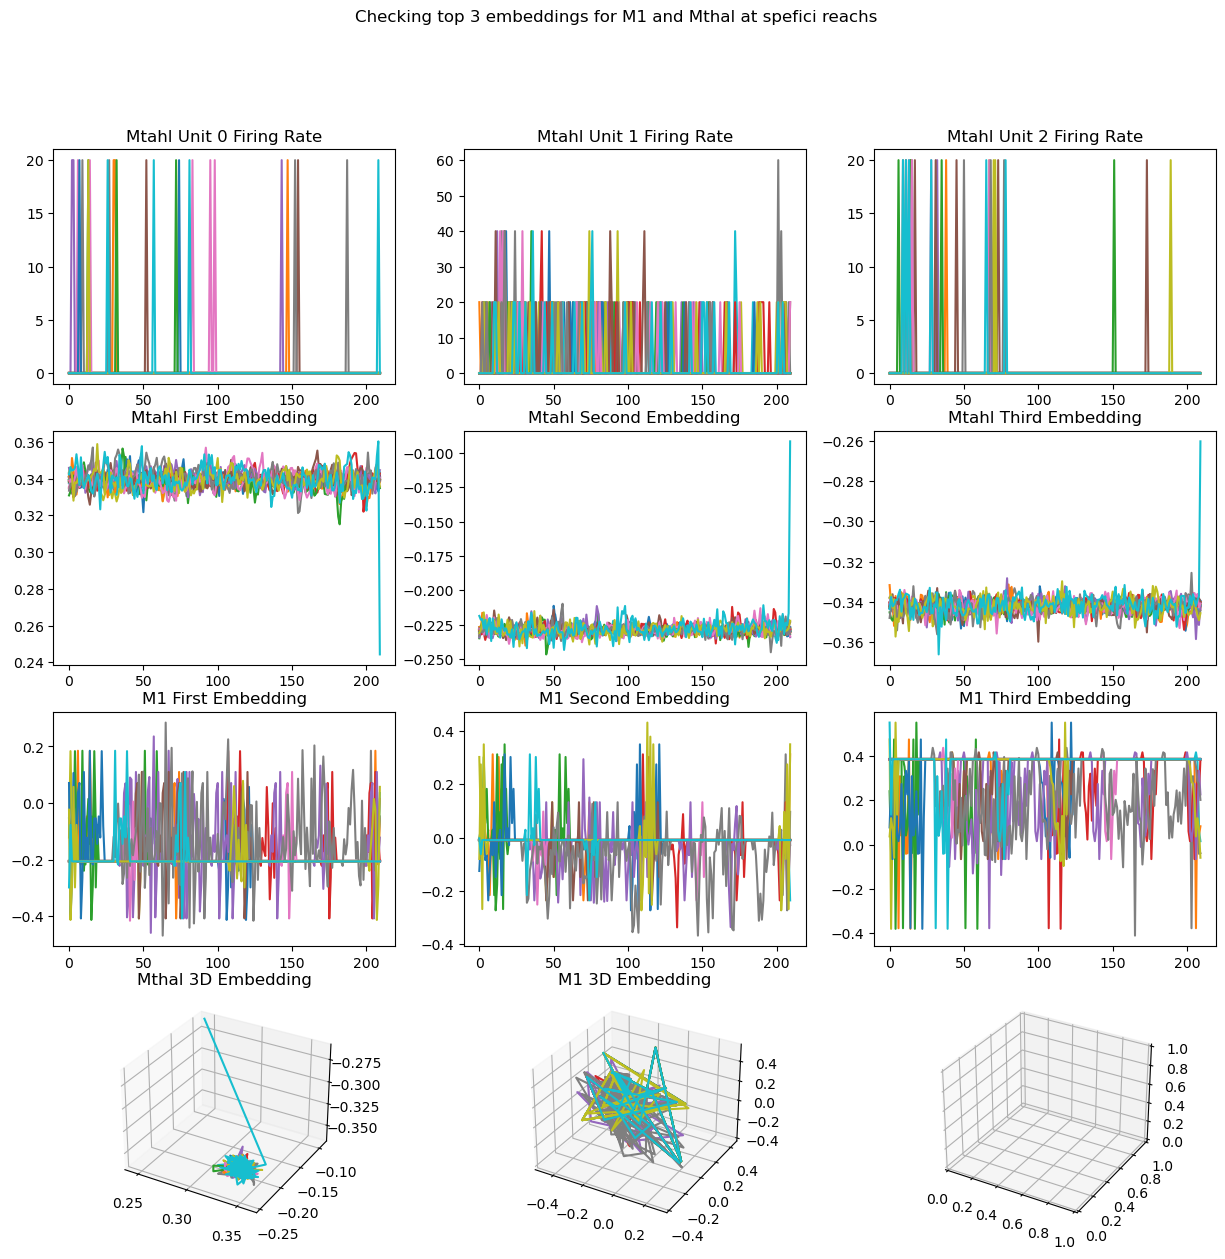

In [228]:
# Units to view
unit_to_view = 0
second_unit_to_view = 1  # Second unit to display
third_unit_to_view = 2

reaches_to_view = range(0, 30)  # Range of reaches to display
view_units(unit_to_view,second_unit_to_view,third_unit_to_view,reaches_to_view)


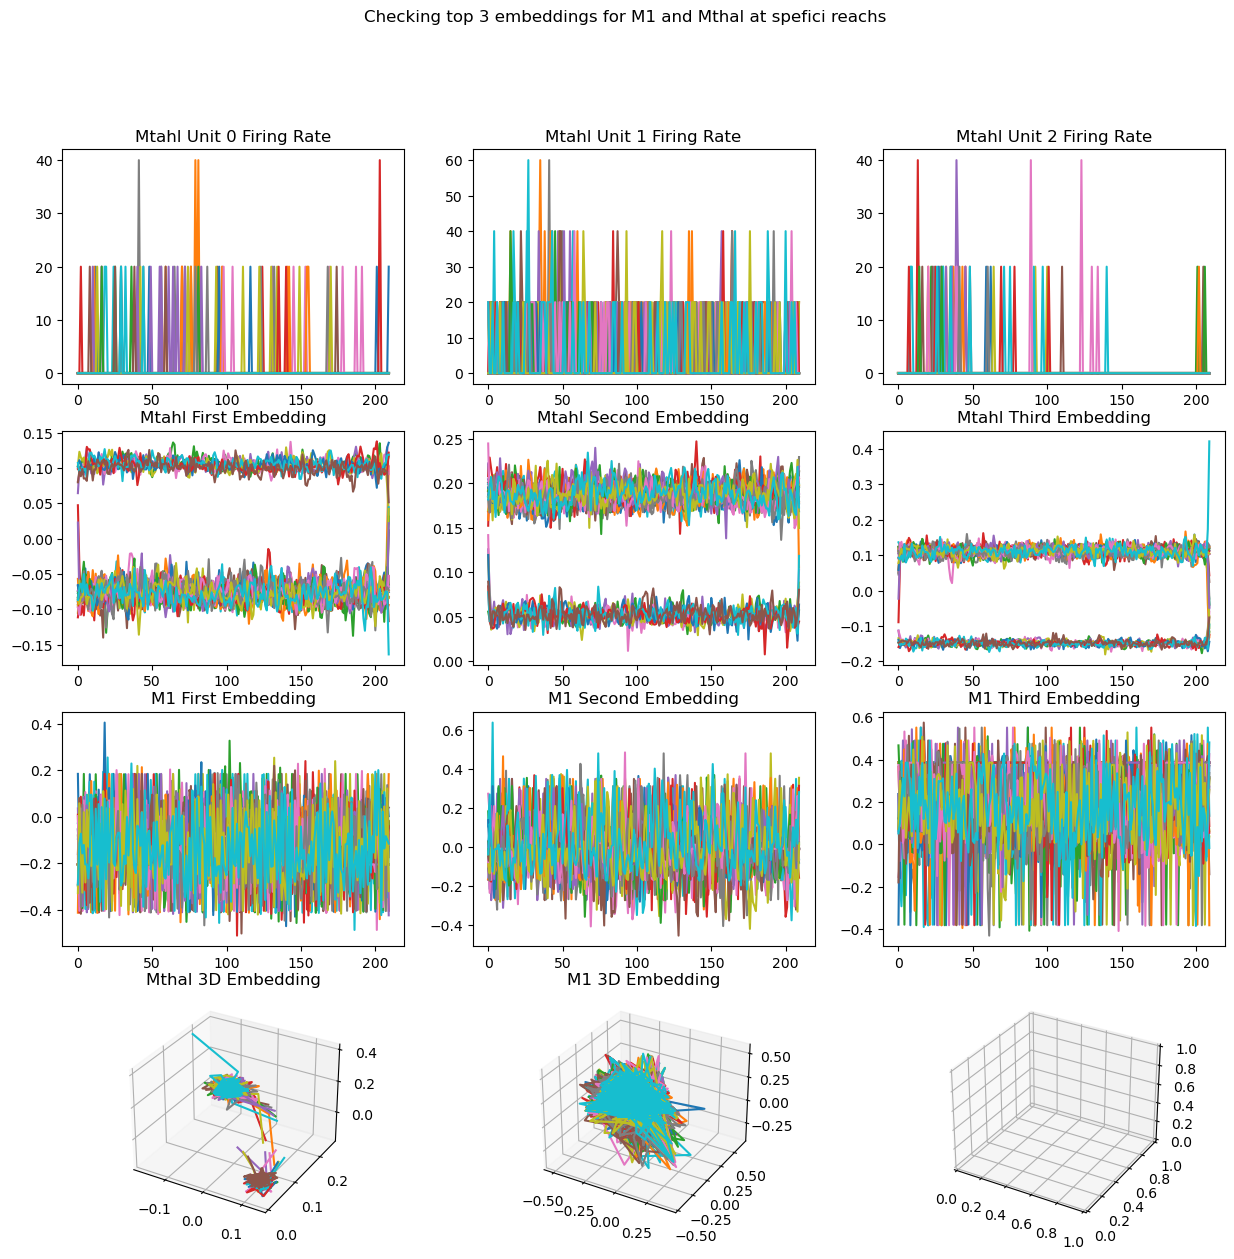

In [229]:

reaches_to_view = range(30, 60)  # Range of reaches to display
view_units(unit_to_view,second_unit_to_view,third_unit_to_view,reaches_to_view)

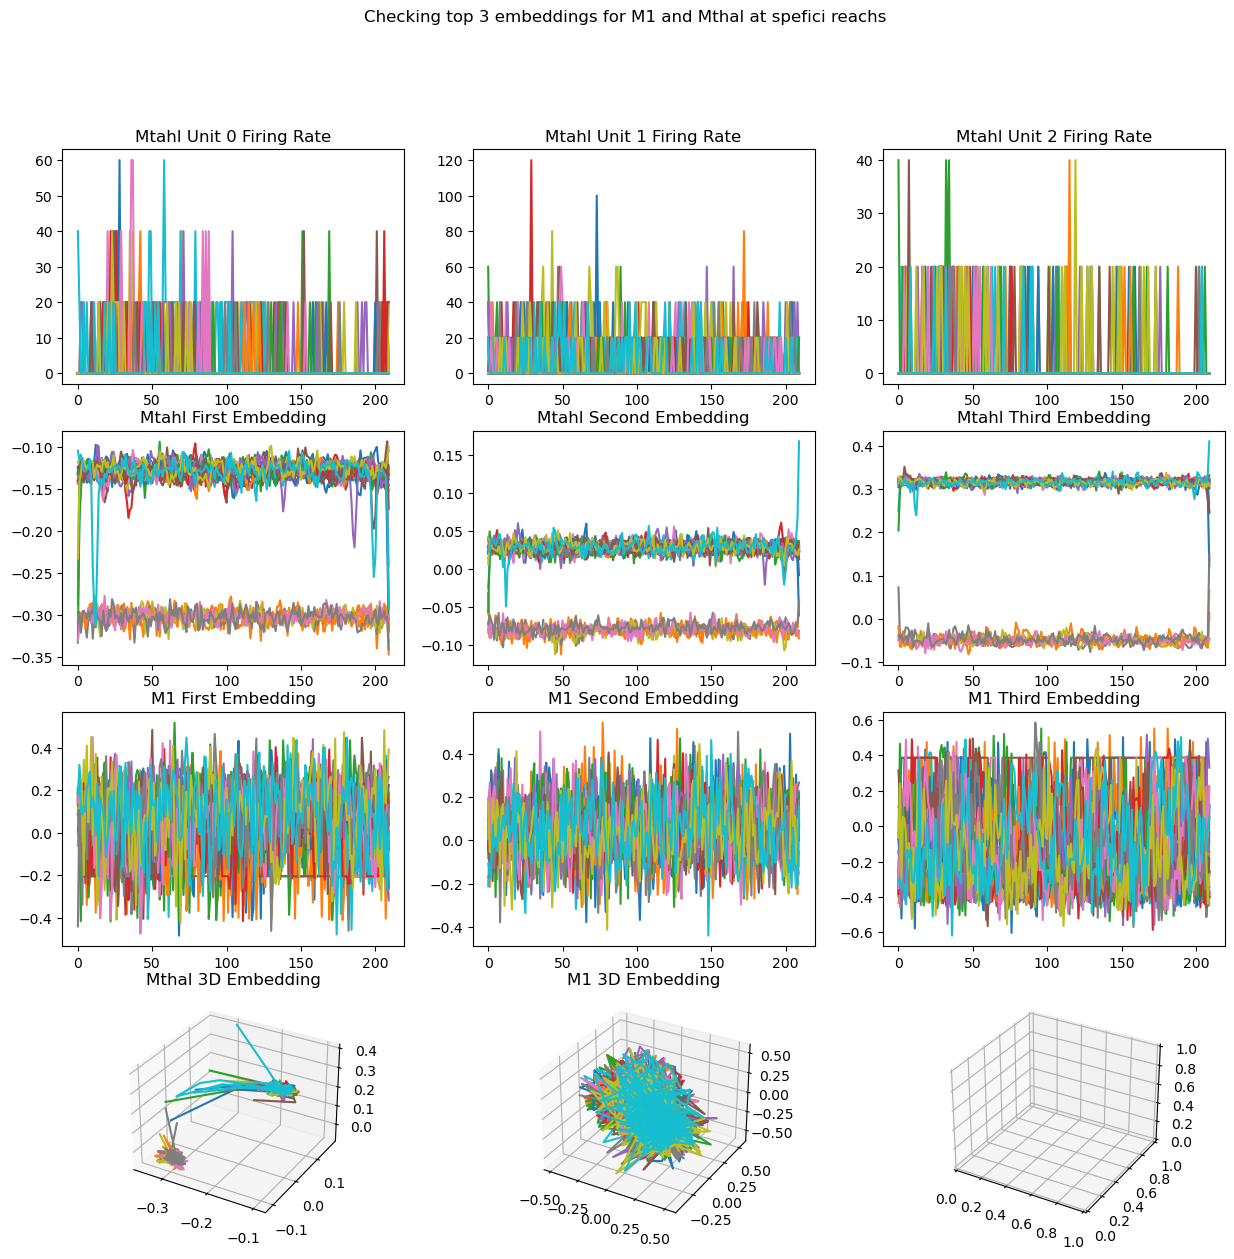

In [227]:
reaches_to_view = range(60, 90)  # Range of reaches to display
view_units(unit_to_view,second_unit_to_view,third_unit_to_view,reaches_to_view)

Convert Data frames into correct Input and Target Shapes

In [113]:
# data = data_m1_neuralData
# data = data_mthal_neuralData
# data = data_mthal_embedding
# data = data_m1_embedding

In [193]:
data_m1_embedding.head()

0         1         2         3         4         5         6   \
0 -0.073559  0.244736 -0.168670  0.215833  0.158538  0.287898 -0.344083   
1 -0.083142  0.241025 -0.165788  0.212391  0.172290  0.288479 -0.341305   
2 -0.067732  0.232326 -0.150467  0.222213  0.203024  0.282449 -0.346628   
3 -0.079314  0.221924 -0.162832  0.225552  0.205842  0.274671 -0.331109   
4 -0.089083  0.200273 -0.155927  0.201847  0.232320  0.268641 -0.340082   

         7         8         9         10        11        12        13  \
0  0.228503 -0.337931 -0.316527  0.154006 -0.364403  0.045566  0.254337   
1  0.232745 -0.348225 -0.320974  0.155636 -0.359394  0.052284  0.244396   
2  0.224617 -0.347567 -0.323250  0.167538 -0.346018  0.036033  0.247537   
3  0.226336 -0.354608 -0.347374  0.154271 -0.349889  0.031295  0.238256   
4  0.264329 -0.345515 -0.334923  0.168902 -0.344538  0.030775  0.224337   

         14        15        16        17        18        19  
0  0.083812 -0.245759  0.024908  0.083340  0.139286 -0.221331  
1  0.087638 -0.240951  0.023535  0.090644  0.141055 -0.210465  
2  0.073056 -0.221419  0.041755  0.078580  0.171407 -0.224706  
3  0.080558 -0.224917  0.048340  0.071508  0.144241 -0.229517  
4  0.103298 -0.240061  0.028711  0.091267  0.157220 -0.207364

In [194]:
data_mthal_embedding.head()

0         1         2         3         4         5         6   \
0 -0.015637  0.406981  0.166465 -0.204488  0.064744 -0.065235 -0.321402   
1 -0.025242  0.398936  0.177669 -0.190722  0.069609 -0.072161 -0.324818   
2 -0.016251  0.397371  0.181832 -0.192369  0.076351 -0.054525 -0.329100   
3 -0.016547  0.375752  0.187431 -0.225253  0.069713 -0.059301 -0.327082   
4 -0.001769  0.355720  0.179429 -0.254513  0.040323 -0.056358 -0.304081   

         7         8         9   ...        22        23        24        25  \
0  0.131802  0.132240 -0.042215  ...  0.094831 -0.044322  0.027663 -0.102902   
1  0.124397  0.135454 -0.022158  ...  0.097464 -0.020535  0.002429 -0.099985   
2  0.128398  0.136818 -0.039634  ...  0.098343 -0.015604 -0.001244 -0.085564   
3  0.101649  0.128980 -0.050475  ...  0.082466 -0.059466  0.019614 -0.071398   
4  0.080656  0.119859 -0.054576  ...  0.106141 -0.126688  0.040213 -0.099998   

         26        27        28        29        30        31  
0  0.064785  0.053596  0.098654  0.042460  0.062349 -0.119618  
1  0.051914  0.035560  0.096073  0.057147  0.055696 -0.135972  
2  0.039650  0.041311  0.073873  0.066599  0.066728 -0.139580  
3  0.038000  0.076543  0.064734  0.062728  0.096867 -0.118303  
4  0.041366  0.066128  0.069432  0.030093  0.113554 -0.072679  

[5 rows x 32 columns]

Adapt the neural or embedding data into train, validate and test sets

In [195]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assuming data_mthal_embedding and data_m1_embedding are your DataFrame names:
PREDICTORS = data_mthal_embedding.columns  # These are all columns in the Mthal embedding DataFrame
TARGET = data_m1_embedding.columns  # These are all columns in the M1 embedding DataFrame


scale the data. take the mean of columns and find SD and so on

In [196]:
scale_taret = True

In [197]:
# Initialize scaler
scaler = StandardScaler()

if scale_taret:
    # Scale Mthal embedding data (predictors)
    data_mthal_embedding_scaled = pd.DataFrame(scaler.fit_transform(data_mthal_embedding), columns=PREDICTORS)

if scale_taret == False:
    data_mthal_embedding_scaled = data_mthal_embedding
    
# Optionally scale M1 embedding data (targets) if needed
if scale_taret:
    data_m1_embedding_scaled = pd.DataFrame(scaler.fit_transform(data_m1_embedding), columns=TARGET)
    print('scaling Target Embeddings')

# Use M1 embedding data as is if not scaling
if scale_taret == False:
    data_m1_embedding_scaled = data_m1_embedding  # Not scaled, just renaming for consistency in downstream code
    print('Not scaling Target Embeddings')


scaling Target Embeddings


checking the scalled embeddings vs the normal unscalled
- The scaled and non-scalled embeddings should look the same, but have different axis values

Shape of array: (61160, 20)


<Axes3D: title={'center': 'Scaled M1 embeddings'}>

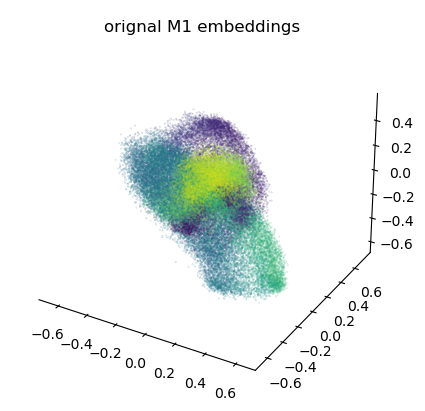

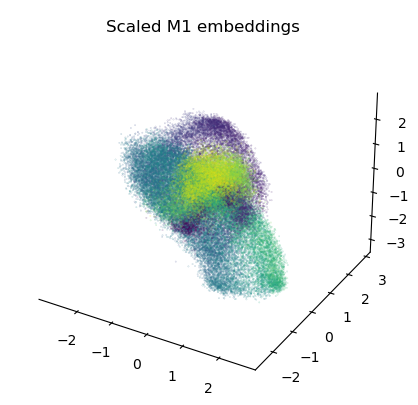

In [198]:
# Using .values to convert DataFrame to array
array_m1_embedding = data_m1_embedding_scaled.values
# Check the shape to ensure it is (61160, 20)
print("Shape of array:", array_m1_embedding.shape)

cebra.plot_embedding(embedding=data_m1_embedding_T, embedding_labels='time', title='orignal M1 embeddings')
cebra.plot_embedding(embedding=array_m1_embedding, embedding_labels='time', title='Scaled M1 embeddings')


Shape of array: (61160, 20)


<Axes3D: title={'center': 'scaled Mthal embeddings'}>

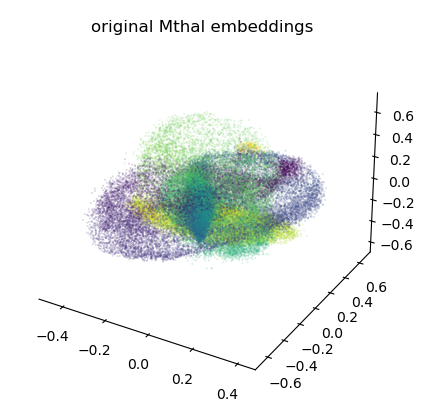

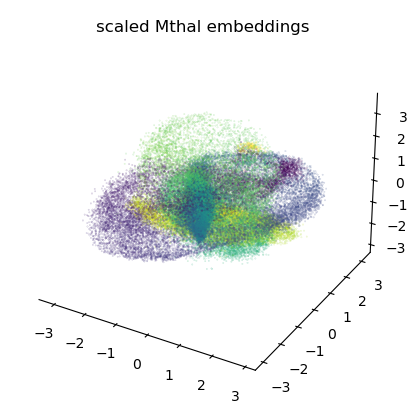

In [199]:
# Using .values to convert DataFrame to array
array_mthal_embedding = data_mthal_embedding_scaled.values
# Check the shape to ensure it is (61160, 20)
print("Shape of array:", array_m1_embedding.shape)

cebra.plot_embedding(embedding=data_mthal_embedding_T, embedding_labels='time', title='original Mthal embeddings')
cebra.plot_embedding(embedding=array_mthal_embedding, embedding_labels='time', title='scaled Mthal embeddings')


Split scaled Data into Train, Validate, and Test Sets

In [200]:
# Combine scaled data into a single DataFrame if needed for splitting (here, not technically necessary)
# We can split directly using indices because our data is already aligned in time

# Determine split sizes
total_samples = len(data_mthal_embedding)
print(f'total samples: {total_samples}')

train_size = int(0.70 * total_samples)
valid_size = int(0.85 * total_samples)
print(f'train_size: {train_size}')
print(f'valid_size: {valid_size}')


# Split data into training, validation, and test sets
train_x = data_mthal_embedding_scaled.iloc[:train_size].to_numpy()
train_y = data_m1_embedding_scaled.iloc[:train_size].to_numpy()

valid_x = data_mthal_embedding_scaled.iloc[train_size:valid_size].to_numpy()
valid_y = data_m1_embedding_scaled.iloc[train_size:valid_size].to_numpy()

test_x = data_mthal_embedding_scaled.iloc[valid_size:].to_numpy()
test_y = data_m1_embedding_scaled.iloc[valid_size:].to_numpy()


total samples: 61160
train_size: 42812
valid_size: 51986


In [201]:
print("Train X:", train_x.shape, train_x[0][0:3])
print("Train Y:", train_y.shape, train_y[0][0:3])
print("Validation X:", valid_x.shape, valid_x[0][0:3])
print("Validation Y:", valid_y.shape, valid_y[0][0:3])
print("Test X:", test_x.shape, test_x[0][0:3])
print("Test Y:", test_y.shape, test_y[0][0:3])
42812 + 6116 + 12232

Train X: (42812, 32) [-0.08068058  1.96602741  0.88747356]
Train Y: (42812, 20) [-0.35367205  0.9865413  -0.9040999 ]
Validation X: (9174, 32) [-0.21890598 -0.93141757  0.32718727]
Validation Y: (9174, 20) [-0.72756274  1.24173265 -1.18254448]
Test X: (9174, 32) [ 1.69187442  0.61237574 -0.49900849]
Test Y: (9174, 20) [ 0.55680525 -0.39867968  1.79391659]


61160

looking at embeddings used for training, validation and test sets

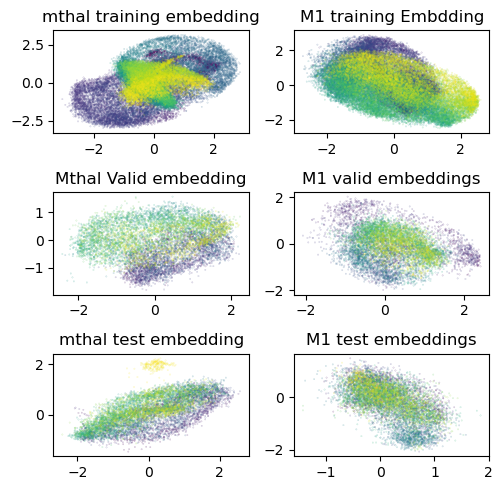

In [202]:
plt.figure(figsize=(5, 5))

index_order = (0,1)

# Creating each subplot in the 3x2 grid
ax1 = plt.subplot(321)  # First row, first column
ax2 = plt.subplot(322)  # First row, second column
ax3 = plt.subplot(323)  # Second row, first column
ax4 = plt.subplot(324)  # Second row, second column
ax5 = plt.subplot(325)  # Third row, first column
ax6 = plt.subplot(326)  # Third row, second column

ax1 = cebra.plot_embedding(ax=ax1,idx_order=index_order,embedding=train_x, embedding_labels='time', title='mthal training embedding')
ax2 = cebra.plot_embedding(ax=ax2,idx_order=index_order,embedding=train_y, embedding_labels='time', title='M1 training Embdding')
ax3 = cebra.plot_embedding(ax=ax3,idx_order=index_order,embedding=valid_x, embedding_labels='time', title='Mthal Valid embedding')
ax4 = cebra.plot_embedding(ax=ax4,idx_order=index_order,embedding=valid_y, embedding_labels='time', title='M1 valid embeddings')
ax5 = cebra.plot_embedding(ax=ax5,idx_order=index_order,embedding=test_x, embedding_labels='time', title='mthal test embedding')
ax6 = cebra.plot_embedding(ax=ax6,idx_order=index_order,embedding=test_y, embedding_labels='time', title='M1 test embeddings')
plt.tight_layout()  # Adjust subplots to fit into figure area.


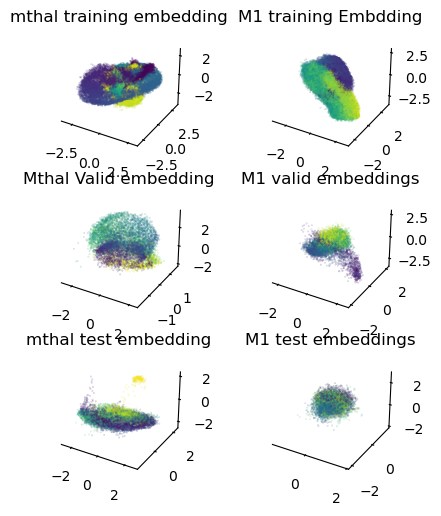

In [203]:
plt.figure(figsize=(5, 5))

index_order = (0,1,2)

# Creating each subplot in the 3x2 grid
ax1 = plt.subplot(321, projection='3d')  # First row, first column
ax2 = plt.subplot(322, projection='3d')  # First row, second column
ax3 = plt.subplot(323, projection='3d')  # Second row, first column
ax4 = plt.subplot(324, projection='3d')  # Second row, second column
ax5 = plt.subplot(325, projection='3d')  # Third row, first column
ax6 = plt.subplot(326, projection='3d')  # Third row, second column

ax1 = cebra.plot_embedding(ax=ax1,idx_order=index_order,embedding=train_x, embedding_labels='time', title='mthal training embedding')
ax2 = cebra.plot_embedding(ax=ax2,idx_order=index_order,embedding=train_y, embedding_labels='time', title='M1 training Embdding')
ax3 = cebra.plot_embedding(ax=ax3,idx_order=index_order,embedding=valid_x, embedding_labels='time', title='Mthal Valid embedding')
ax4 = cebra.plot_embedding(ax=ax4,idx_order=index_order,embedding=valid_y, embedding_labels='time', title='M1 valid embeddings')
ax5 = cebra.plot_embedding(ax=ax5,idx_order=index_order,embedding=test_x, embedding_labels='time', title='mthal test embedding')
ax6 = cebra.plot_embedding(ax=ax6,idx_order=index_order,embedding=test_y, embedding_labels='time', title='M1 test embeddings')
plt.tight_layout()  # Adjust subplots to fit into figure area.


<Axes3D: title={'center': 'training M1 Target embeddings'}>

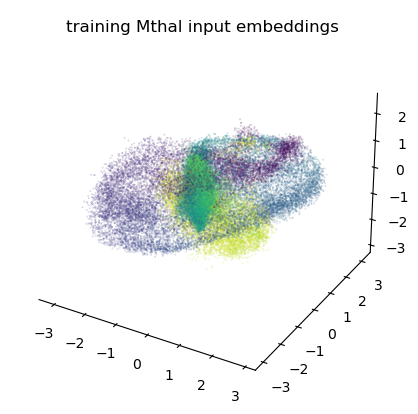

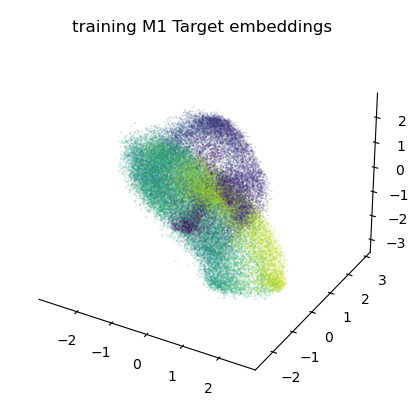

In [124]:

cebra.plot_embedding(embedding=train_x, embedding_labels='time', title='training Mthal input embeddings')
cebra.plot_embedding(embedding=train_y, embedding_labels='time', title='training M1 Target embeddings')

### 2. Construct RNN

In [206]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

prepare input and target data

In [207]:
input = train_x
target = train_y
test_input = test_x
test_target = test_y
input.shape, target.shape, test_input.shape,  test_target.shape

((42812, 32), (42812, 20), (9174, 32), (9174, 20))

In [208]:
# Now reshape input and target tensors for the training set
input_tensor = torch.tensor(input)  # Reshape to (222, 210, 32)
target_tensor = torch.tensor(target) # Reshape to (222, 210, 32)
test_input_tensor = torch.tensor(test_input)
test_target_tensor = torch.tensor(test_target)


# Convert the existing tensors to float32 if they are not already
input_tensor = input_tensor.float()
target_tensor = target_tensor.float()
test_input_tensor = test_input_tensor.float()
test_target_tensor = test_target_tensor.float()

# Create a TensorDataset
train_dataset = TensorDataset(input_tensor, target_tensor)
test_dataset = TensorDataset(test_input_tensor, test_target_tensor)


# Optionally create a validation dataset using the remaining data if needed
input_tensor.shape, target_tensor.shape, test_input_tensor.shape, test_target_tensor.shape

(torch.Size([42812, 32]),
 torch.Size([42812, 20]),
 torch.Size([9174, 32]),
 torch.Size([9174, 20]))

In [209]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# # Create a TensorDataset
# dataset = TensorDataset(input_tensor, target_tensor)
# print(len(dataset))

# # Split into train and validation
# train_size = int(0.8 * len(dataset))
# print(train_size)
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataset = [(input_tensor, target_tensor)]
val_dataset = [(torch.tensor(valid_x).float(), torch.tensor(valid_y).float())]

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

testing batching and randomizing inputs

In [210]:
input_tensor.shape, target_tensor.shape

(torch.Size([42812, 32]), torch.Size([42812, 20]))

In [215]:
from torch.utils.data import Dataset, DataLoader
import random

class WeatherDataset(Dataset):
    def __init__(self, features, labels, sequence_length=7):
        self.features = features
        self.labels = labels
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.labels) - self.sequence_length + 1

    def __getitem__(self, index):
        idx = random.randint(0, len(self.labels) - self.sequence_length)
        return (self.features[idx:idx + self.sequence_length], self.labels[idx:idx + self.sequence_length])

# Assuming 'features' and 'labels' are your full datasets
dataset = WeatherDataset(input_tensor, target_tensor)
train_loader = DataLoader(dataset, batch_size=1, shuffle=False)  # Shuffle here might not be necessary


PyTorch rnn #1
- no dropouts

In [216]:
# Adjusting the model for the specific neural data task
class NeuralRNN(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=1, output_size=1):
        super(NeuralRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)  # Apply the linear layer to each time step
        return out

# Create an instance of the NeuralRNN
neural_rnn = NeuralRNN()



pytorch rnn #2
- added drop outs

In [217]:
input_tensor.shape, target_tensor.shape

(torch.Size([42812, 32]), torch.Size([42812, 20]))

In [218]:
input_size = len(input_tensor[1].detach().numpy())
output_size = len(target_tensor[1].detach().numpy())
print(input_size, output_size)

class NeuralRNN(nn.Module):
    def __init__(self, input_size=input_size, hidden_size=64, num_layers=1, output_size=output_size, dropout=0.5):
        super(NeuralRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Apply dropout to each RNN layer except the last layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)  # Apply the linear layer to each time step
        return out

# Create an instance of the NeuralRNN
neural_rnn = NeuralRNN()

32 20


### 3. Train RNN 
- Input: Mthal embedding data
- Targert: M1 embedding data
- Output: Predicted M1 embedding data

In [219]:
num_epochs = 100
lr = 0.001
weight_decay = True
early_stop = True

# Initialize early stopping criteria
early_stopping_patience = 10
min_val_loss = float('inf')
stop_counter = 0

In [220]:
i = 0
for inputs, targets in train_loader:
    i +=1
    print(f'Epoch {i}')
    print(inputs.shape)
    print(targets.shape)
    print(inputs[0][0].shape, inputs[0][0])
    print(targets[0][0].shape, targets[0][0])
    break

Epoch 1
torch.Size([1, 7, 32])
torch.Size([1, 7, 20])
torch.Size([32]) tensor([-0.3874,  1.7448,  0.8568, -0.4583,  0.1419, -0.6549,  0.6877, -0.4084,
        -1.1968, -1.2482, -1.0467, -1.4854,  0.0796, -1.2822, -1.2556, -0.3527,
         0.0733,  0.4354,  0.5236, -0.6208,  2.1185, -0.6533,  0.3485,  0.5173,
         0.5879,  1.4567,  2.2194,  0.7779,  1.0298, -0.8366,  1.4834,  0.2807])
torch.Size([20]) tensor([-1.9737,  1.1413, -0.4863, -0.5278, -0.6878, -0.6000,  1.2857,  0.8467,
        -0.9351, -0.1533,  0.1652, -1.5982,  0.6895,  0.3925,  1.5275, -0.8103,
         0.3997,  1.3897, -1.6784, -0.2396])


In [221]:

for inputs, targets in val_loader:
    print(inputs.shape)
    print(targets.shape)
    print(inputs[0][1].shape, inputs[0][1])
    print(targets[0][1].shape, targets[0][1])
    break


torch.Size([1, 9174, 32])
torch.Size([1, 9174, 20])
torch.Size([32]) tensor([-0.0656, -1.0645,  0.1526,  1.5407, -0.0449,  0.9749,  1.3168,  0.7992,
         0.2321, -0.1120, -1.2899, -0.7732, -1.1484,  0.0547,  0.5906,  1.5371,
         1.4886,  1.7873,  2.5166, -1.4346, -0.2287, -0.7019,  0.6468, -0.2725,
         1.2711,  1.1607, -0.7699, -0.5172, -0.6951, -0.2138, -0.2654, -0.7126])
torch.Size([20]) tensor([-0.7190,  1.1609, -1.5334,  1.7005, -0.8948, -0.0985, -0.7291, -0.9487,
         0.2037, -0.7953,  1.2769,  0.1009,  1.5005, -1.0683, -1.5183,  0.3565,
         0.0992, -0.1975, -0.2246,  1.4250])


In [222]:
num_epochs = 1000
lr = 0.001
weight_decay = True
early_stop = True

# Initialize early stopping criteria
early_stopping_patience = 10
min_val_loss = float('inf')
stop_counter = 0

In [223]:
import torch
loss_function = torch.nn.MSELoss()  # Mean Squared Error Loss, or choose another appropriate to your task


optimizer = torch.optim.Adam(neural_rnn.parameters(), lr=lr)  # Using Adam optimizer

if weight_decay:
    optimizer = torch.optim.Adam(neural_rnn.parameters(), lr=lr, weight_decay=0.01)  # Adding L2 regularization

predictions = []
valid_predictions = []
weight_history = []
# Assuming neural_rnn, train_loader, and val_loader are already defined
for epoch in range(num_epochs):
    print(f'epoch: {epoch}')
    # Training phase
   
    neural_rnn.train()  # Set the model to training mode
    train_loss = 0.0
    all_outputs = []
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Clear the gradients
        outputs = neural_rnn(inputs)  # Forward pass: compute the output
        loss = loss_function(outputs, targets)
           # Print epoch statistics every 100 epochs
        # if epoch % 20 == 0:
        #     print(epoch)
        #     print(inputs[0][epoch])
        #     print(targets[0][epoch])
        #     print(outputs[0,:,:])
        #     print(outputs[0,:,:].shape)
        #     print('')
        loss.backward()  # Backward pass: compute the gradient of the loss with respect to model parameters
        optimizer.step()  # Update parameters
        train_loss += loss.item() * inputs.size(0)  # Multiply by batch size to undo averaging in loss calculation
        all_outputs.append(outputs)

        # Save weights
        layer_weights = {name: parameter.data.clone() for name, parameter in neural_rnn.named_parameters()}
        weight_history.append(layer_weights)
    all_outputs = torch.cat(all_outputs, dim=0)  # Concatenate along the batch dimension
    train_loss /= len(train_loader.dataset)  # Average loss for the epoch

    # Validation phase
    neural_rnn.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    all_val_outputs = []
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for inputs, targets in val_loader:
            outputs_val = neural_rnn(inputs)
            loss = loss_function(outputs_val, targets)
            val_loss += loss.item() * inputs.size(0)
            # if epoch % 20 == 0:
            #     print('val')
            #     print(inputs[0][epoch])
            #     print(targets[0][epoch])
            #     print(outputs_val[0][epoch])
            #     print('')
            all_val_outputs.append(outputs_val)

    all_val_outputs = torch.cat(all_val_outputs, dim=0)  
    val_loss /= len(val_loader.dataset)  # Average loss for the epoch

    
    # # Early stopping check
    if early_stop:
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            stop_counter = 0  # reset the counter if improvement is seen
        else:
            stop_counter += 1
        if stop_counter >= early_stopping_patience:
            print(f"Stopping early at epoch {epoch+1}")
            break

    # Print epoch statistics every 100 epochs
    print(f'Epoch {epoch+1} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {val_loss:.4f}')

    if epoch % 100 == 0:        
        print(inputs[0][epoch])
        print(targets[0][epoch])
        print(outputs[0,:,:])
        print(outputs[0,:,:].shape)
        print('')


epoch: 0
Epoch 1 	Training Loss: 0.4272 	Validation Loss: 1.8585
tensor([-0.2189, -0.9314,  0.3272,  1.6067,  0.2740,  0.9776,  1.2304,  0.9189,
         0.3325, -0.1173, -1.5530, -0.7286, -1.0322,  0.1267,  0.3866,  1.4077,
         1.5199,  1.4486,  2.5912, -1.7507, -0.2449, -0.7621,  0.9173, -0.2538,
         1.2521,  1.1322, -0.6810, -0.4138, -0.8199, -0.0921, -0.2690, -0.6085])
tensor([-0.7276,  1.2417, -1.1825,  1.4737, -0.7956, -0.2730, -0.5698, -1.2367,
         0.1504, -0.3879,  1.4908,  0.2503,  1.4250, -1.3242, -1.4605,  0.2981,
         0.1194, -0.4046, -0.2033,  1.4544])
tensor([[ 0.5610,  0.1749,  0.0150, -1.2275,  0.0494,  0.8824, -0.2853, -0.0244,
          0.7341,  1.2498,  0.3294,  0.5865,  0.7255, -0.5942,  0.4311,  0.2930,
         -0.2090,  0.6837,  0.8218,  0.0709],
        [ 0.6728,  0.2080,  0.0498, -1.6034,  0.1635,  1.1526, -0.4266,  0.0745,
          0.9137,  1.4736,  0.3433,  0.5833,  1.0705, -0.7844,  0.5769,  0.5563,
         -0.1918,  0.9062,  1.0520,  0.

In [ ]:
train_x[-1], train_y[-1],
train_y.shape, train_x.shape

NameError: name 'train_x' is not defined

In [59]:
# output_predictions = all_outputs.detach().numpy()
# print(output_predictions.shape)
# output_predictions = output_predictions.squeeze(axis=2)
# output_predictions_batch1 = output_predictions[:,0]
# output_predictions_batch2 = output_predictions[:,1]
# output_predictions_batch3 = output_predictions[:,2]
# output_predictions_batch4 = output_predictions[:,3]
# output_predictions_batch5 = output_predictions[:,4]
# output_predictions_batch6 = output_predictions[:,5]
# output_predictions_batch7 = output_predictions[:,6]

# output_predictions_batch1.shape

In [60]:
output_predictions = all_outputs.detach().numpy()
print(output_predictions.shape)

# If you want each batch's data separately
output_predictions_batch1 = output_predictions[:, 0, :]  # All time steps, first batch, all features
output_predictions_batch2 = output_predictions[:, 1, :]
output_predictions_batch3 = output_predictions[:, 2, :]
output_predictions_batch4 = output_predictions[:, 3, :]
output_predictions_batch5 = output_predictions[:, 4, :]
output_predictions_batch6 = output_predictions[:, 5, :]
output_predictions_batch7 = output_predictions[:, 6, :]

# Example: Print the shape of the first batch's data
print(output_predictions_batch1.shape)


(42806, 7, 20)
(42806, 20)


In [63]:
# Define the batch and the time bins range
batch_index = 0  # Batch 7 in human-readable form, but index 6 in zero-based indexing
time_bins_range = slice(0, -1)  # This is equivalent to [0:220]
print(time_bins_range)
feature_index = 0  # First column of the embeddings

# Extract the specific slice of data
rnn_output_embeddings_1 = output_predictions[time_bins_range, batch_index, feature_index]
rnn_output_embeddings_2 = output_predictions[time_bins_range, batch_index, 1]
rnn_output_embeddings_3 = output_predictions[time_bins_range, batch_index, 2]


# Printing the shape and the data
print("Shape of selected embeddings:", rnn_output_embeddings_2.shape,rnn_output_embeddings_3.shape)


slice(0, -1, None)
Shape of selected embeddings: (42805,) (42805,)


In [64]:
print(train_y.shape)
# target_m1_embeddings = train_y.squeeze(axis=1)
target_m1_embeddings = train_y
target_m1_embeddings.shape
target_m1_embeddings_df = pd.DataFrame(target_m1_embeddings)
target_m1_embeddings_df.head(2)


(42812, 20)


0         1         2         3         4         5         6   \
0 -0.073559  0.244736 -0.168670  0.215833  0.158538  0.287898 -0.344083   
1 -0.083142  0.241025 -0.165788  0.212391  0.172290  0.288479 -0.341305   

         7         8         9         10        11        12        13  \
0  0.228503 -0.337931 -0.316527  0.154006 -0.364403  0.045566  0.254337   
1  0.232745 -0.348225 -0.320974  0.155636 -0.359394  0.052284  0.244396   

         14        15        16        17        18        19  
0  0.083812 -0.245759  0.024908  0.083340  0.139286 -0.221331  
1  0.087638 -0.240951  0.023535  0.090644  0.141055 -0.210465

In [65]:
rnn_output_embeddings_1_df = pd.DataFrame(rnn_output_embeddings_1)
rnn_output_embeddings_2_df = pd.DataFrame(rnn_output_embeddings_2)
rnn_output_embeddings_3_df = pd.DataFrame(rnn_output_embeddings_3)


In [71]:
# Units to view
unit_to_view = 4
second_unit_to_view = 60  # Second unit to display
third_unit_to_view = 100
reaches_to_view = range(0, 2)  # Range of reaches to display

# Assuming data_mthal_neuralData_T and data_mthal_embedding_T are correctly set up
for reach in reaches_to_view:
    # Calculate the start and end indices for each reach
    reach_start = reach * 220
    reach_end = reach_start + 220
    embedding_1_rnn = rnn_output_embeddings_1_df[0].to_numpy()[reach_start:reach_end]
    embedding_2_rnn = rnn_output_embeddings_2_df[0].to_numpy()[reach_start:reach_end]
    embedding_3_rnn = rnn_output_embeddings_3_df[0].to_numpy()[reach_start:reach_end]

    embedding_1_m1 = target_m1_embeddings_df[0].to_numpy()[reach_start:reach_end]
    embedding_2_m1 = target_m1_embeddings_df[1].to_numpy()[reach_start:reach_end]
    embedding_3_m1 = target_m1_embeddings_df[2].to_numpy()[reach_start:reach_end]
    embedding_1_rnn[0:3], embedding_1_m1[0:3]

In [72]:
data_mthal_neuralData_T

array([[ 0.,  0.,  0., ..., 20.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 40.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [76]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

def view_rnn_predictions(unit_to_view,second_unit_to_view,third_unit_to_view,reaches_to_view):

    # Close any previous plots
    plt.close('all')

    # Create a new figure with a specific size
    fig = plt.figure(figsize=(15, 14))

    # First row
    ax1 = fig.add_subplot(431)  # First row, first column
    ax2 = fig.add_subplot(432)  # First row, second column
    ax3 = fig.add_subplot(433)  # First row, third column

    # Second row
    ax4 = fig.add_subplot(434)  # Second row, first column
    ax5 = fig.add_subplot(435)  # Second row, second column
    ax6 = fig.add_subplot(436)  # Second row, third column

    # Third row
    ax7 = fig.add_subplot(437)  # Third row, first column
    ax8 = fig.add_subplot(438)  # Third row, second column
    ax9 = fig.add_subplot(439)  # Third row, third column

    # Fourth row
    ax10 = fig.add_subplot(4, 3, 10,projection='3d')  # Fourth row, first column
    ax11 = fig.add_subplot(4, 3, 11,projection='3d')  # Fourth row, second column
    ax12 = fig.add_subplot(4, 3, 12, projection='3d')  # Fourth row, third column

 
    # Assuming data_mthal_neuralData_T and data_mthal_embedding_T are correctly set up
    for reach in reaches_to_view:
        # Calculate the start and end indices for each reach
        reach_start = reach * 220
        reach_end = reach_start + 220

        # Fetch data for the specified reach
        unit_frs = data_mthal_neuralData[unit_to_view].to_numpy()[reach_start:reach_end]
        second_unit_frs = data_mthal_neuralData[second_unit_to_view].to_numpy()[reach_start:reach_end]
        third_unit_frs = data_mthal_neuralData[third_unit_to_view].to_numpy()[reach_start:reach_end]

        embedding_1_rnn = rnn_output_embeddings_1_df[0].to_numpy()[reach_start:reach_end]
        embedding_2_rnn = rnn_output_embeddings_2_df[0].to_numpy()[reach_start:reach_end]
        embedding_3_rnn = rnn_output_embeddings_3_df[0].to_numpy()[reach_start:reach_end]

        embedding_1_m1 = target_m1_embeddings_df[0].to_numpy()[reach_start:reach_end]
        embedding_2_m1 = target_m1_embeddings_df[1].to_numpy()[reach_start:reach_end]
        embedding_3_m1 = target_m1_embeddings_df[2].to_numpy()[reach_start:reach_end]

        # Plotting data for the specified reach, first unit
        ax1.plot(unit_frs, label=f'Reach {reach}')
        ax2.plot(second_unit_frs, label=f'Reach {reach}')
        ax3.plot(third_unit_frs, label=f'Reach {reach}')

        # Plotting data for the specified reach, second unit
        ax4.plot(embedding_1_rnn, label=f'Reach {reach}')
        ax5.plot(embedding_2_rnn, label=f'Reach {reach}')
        ax6.plot(embedding_3_rnn,  label=f'Reach {reach}')

        
        # Plotting data for the specified reach, second unit
        ax7.plot(embedding_1_m1, label=f'Reach {reach}')
        ax8.plot(embedding_2_m1, label=f'Reach {reach}')
        ax9.plot(embedding_3_m1,  label=f'Reach {reach}')

        ax10.plot(embedding_1_rnn, embedding_2_rnn, embedding_3_rnn, label=f'Reach {reach}')
        ax11.plot(embedding_1_m1, embedding_2_m1, embedding_3_m1, label=f'Reach {reach}')



    # Adding legends to each subplot
    # for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    #     ax.legend()
    # Setting titles for subplots, first unit
    ax1.set_title(f"Mtahl Unit {unit_to_view} Firing Rate")
    ax2.set_title(f"Mtahl Unit {second_unit_to_view} Firing Rate")
    ax3.set_title(f"Mtahl Unit {third_unit_to_view} Firing Rate")

    # Setting titles for subplots, second unit
    ax4.set_title("Rnn Prediction 1st Embedding")
    ax5.set_title("Rnn Prediction 2nd Embedding")
    ax6.set_title("Rnn Prediction 3rd Embedding")

    ax7.set_title("M1 1st Embedding")
    ax8.set_title("M1 2nd Embedding")
    ax9.set_title("M1 3rd Embedding")

    ax10.set_title("Rnn 3D Embedding")
    ax11.set_title("M1 3D Embedding")


    # Overall title for the figure
    fig.suptitle(f'Checking top 3 embeddings for M1 and Mthal at spefici reachs')

    # Show the plot
    plt.show()


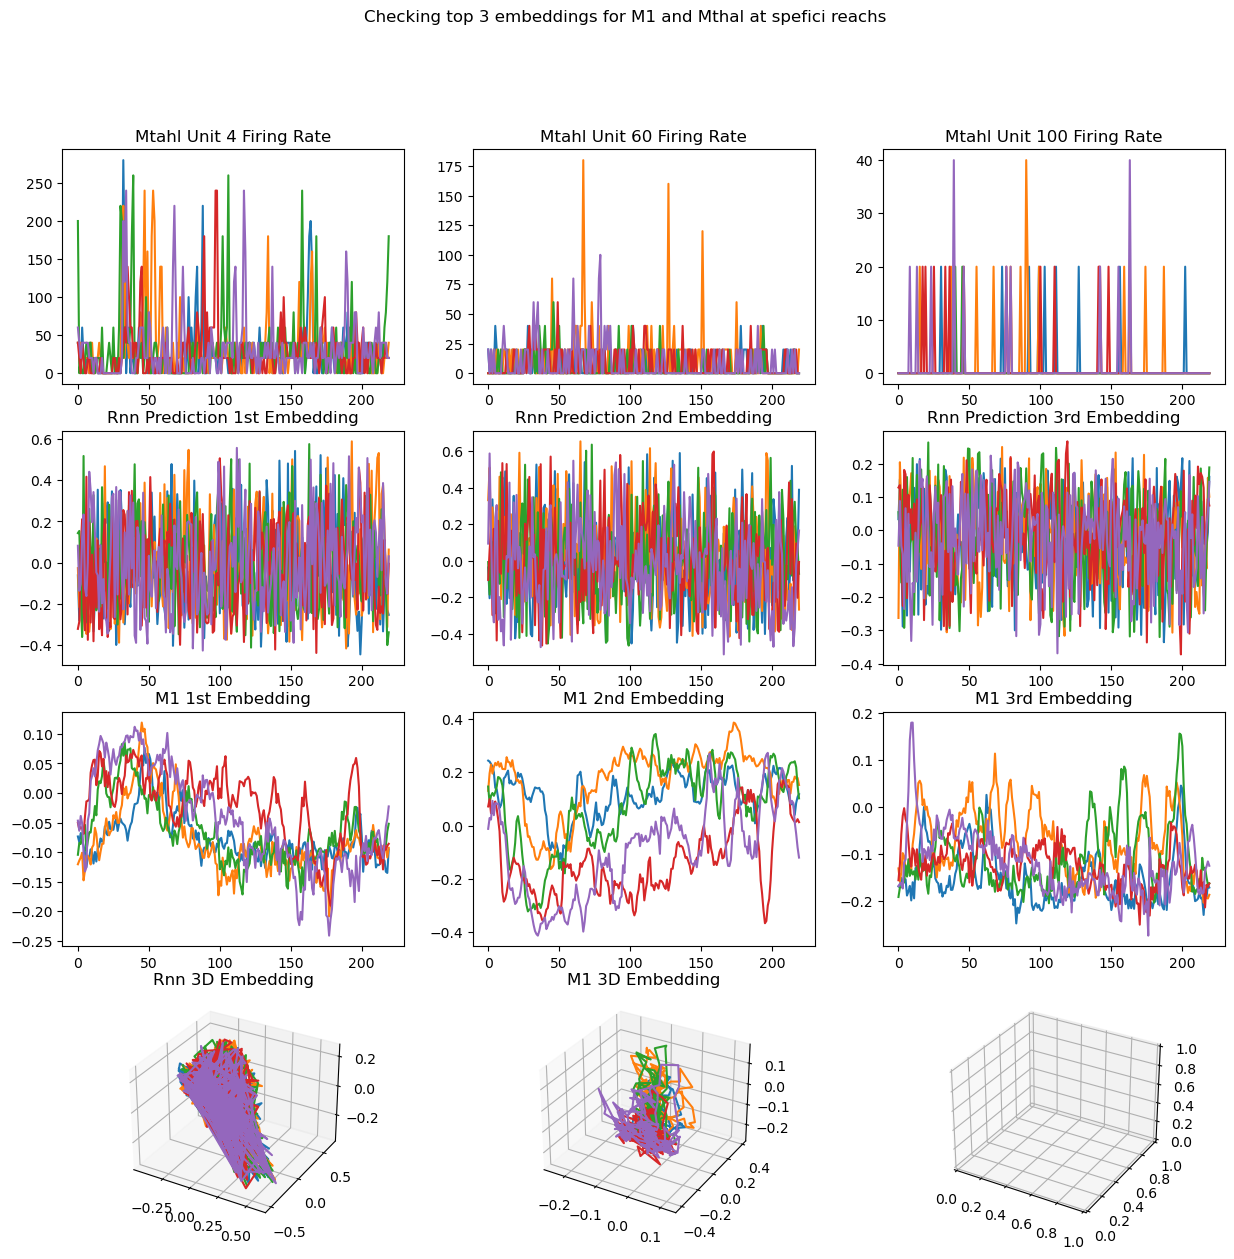

In [77]:
# Units to view
unit_to_view = 4
second_unit_to_view = 60  # Second unit to display
third_unit_to_view = 100
reaches_to_view = range(0, 5)  # Range of reaches to display

view_rnn_predictions(unit_to_view,second_unit_to_view,third_unit_to_view,reaches_to_view)

NameError: name 'rnn_output_embedding' is not defined

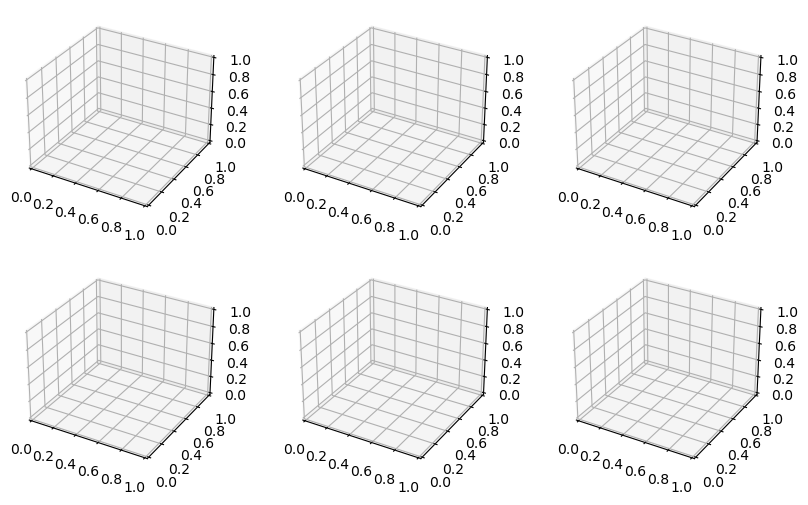

In [78]:
plt.figure(figsize=(10, 6))

index_order = (0,1,2)

#  Creating each subplot in the 5x2 grid
ax1 = plt.subplot(231, projection='3d')  # First row, first column
ax2 = plt.subplot(232, projection='3d')  # First row, second column
ax3 = plt.subplot(233, projection='3d')  # First row, second column
ax4 = plt.subplot(234, projection='3d')  # First row, second column
ax5 = plt.subplot(235, projection='3d')  # First row, second column
ax6 = plt.subplot(236, projection='3d')  # First row, second column

ax1 = cebra.plot_embedding(ax=ax1,idx_order=index_order,embedding=rnn_output_embedding, embedding_labels='time', title='rnn output')
ax2 = cebra.plot_embedding(ax=ax2,idx_order=index_order,embedding=input, embedding_labels='time', title='Mthal rnn Input')
ax3 = cebra.plot_embedding(ax=ax3,idx_order=index_order,embedding=target, embedding_labels='time', title='M1 rnn target')
ax4 = cebra.plot_embedding(ax=ax4,idx_order=index_order,embedding=rnn_output_embedding, embedding_labels=discete_lables[:,0], title='rnn output')
ax5 = cebra.plot_embedding(ax=ax5,idx_order=index_order,embedding=input, embedding_labels=discete_lables[:,0], title='Mthal rnn input')
ax6 = cebra.plot_embedding(ax=ax6,idx_order=index_order,embedding=target, embedding_labels=discete_lables[:,0], title='M1 rnn target')

# add title
plt.suptitle('M1 Vs. Rnn embeddings')

In [79]:
# import matplotlib.pyplot as plt

# day_start = 0
# day_end = 10
# plt.figure(figsize=(15, 7))
# # plt.plot(targets, label='Actual Weather', color='blue', alpha=0.75)
# plt.plot(target_weather[day_start:day_end], label='Target Weather', linestyle='-', color='red', alpha=0.75)
# plt.plot(rnn_output_embeddings_1_df[day_start:day_end], label='Predicted Weather 1', linestyle='-', color='blue', alpha=0.75)
# plt.plot(rnn_output_embeddings_6_df[day_start:day_end], label='Predicted Weather 6', linestyle='-', color='green', alpha=0.75)

# plt.title('Comparison of Actual and Predicted Weather')
# plt.xlabel('Days')
# plt.ylabel('Weather Metric')
# plt.legend()
# plt.grid(True)
# plt.show()

# day_start = -10
# day_end = -1
# plt.figure(figsize=(15, 7))
# # plt.plot(targets, label='Actual Weather', color='blue', alpha=0.75)
# plt.plot(target_weather[day_start:day_end], label='Target Weather', linestyle='-', color='red', alpha=0.75)
# plt.plot(rnn_output_embeddings_1_df[day_start:day_end], label='Predicted embedding 1', linestyle='-', color='blue', alpha=0.75)
# plt.plot(rnn_output_embeddings_6_df[day_start:day_end], label='Predicted embedding 7', linestyle='-', color='green', alpha=0.75)

# plt.title('Comparison of Actual and Predicted Weather')
# plt.xlabel('Days')
# plt.ylabel('Weather Metric')
# plt.legend()
# plt.grid(True)
# plt.show()

### 4. Test rnn on unseen data

In [80]:
test_input_tensor.shape, test_target_tensor.shape

(torch.Size([9174, 32]), torch.Size([9174, 20]))

create dataloader for unseen test data (data witheld from both training and validation)

In [81]:
from torch.utils.data import Dataset, DataLoader
import torch

class SequentialWeatherDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)  # shape: [2027, 3]
        self.labels = torch.tensor(labels, dtype=torch.float32)  # shape: [2027, 1]

    def __len__(self):
        return len(self.features) - 7 + 1  # Account for the last 7-day window

    def __getitem__(self, index):
        # Return 7 consecutive days of features and labels
        return self.features[index:index + 7], self.labels[index:index + 7]

# Assuming test_input_tensor and test_target_tensor are your datasets
test_dataset = SequentialWeatherDataset(test_input_tensor, test_target_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


C:\Users\user\AppData\Local\Temp\ipykernel_14248\2933115460.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)  # shape: [2027, 3]
C:\Users\user\AppData\Local\Temp\ipykernel_14248\2933115460.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.float32)  # shape: [2027, 1]


Run a single pass of the already trained rnn on this unseen data
- makes prediction on unseen data (does not update the rnn in anyway)

In [82]:
neural_rnn.eval()  # Set the model to evaluation mode
test_predictions = []
test_targets = []
test_losses = []

with torch.no_grad():  # No gradients needed for evaluation, which saves memory and computations
    for inputs, targets in test_loader:
        outputs = neural_rnn(inputs)
        loss = loss_function(outputs, targets)
        test_losses.append(loss.item())
        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

test_weather_predictions = np.array(test_predictions)
test_weather_targets = np.array(test_targets)
print(test_weather_predictions.shape, test_weather_targets.shape)
# Calculate average test loss
average_test_loss = sum(test_losses) / len(test_losses)
print(f"Average Test Loss: {average_test_loss:.4f}")


(9168, 7, 20) (9168, 7, 20)
Average Test Loss: 0.0849


evaluate rnn's prediction on unseen data

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Flatten the lists if they are nested due to sequence predictions
test_predictions = [item for sublist in test_predictions for item in sublist]
test_targets = [item for sublist in test_targets for item in sublist]

mse = mean_squared_error(test_targets, test_predictions)
mae = mean_absolute_error(test_targets, test_predictions)

print(f"Mean Squared Error on Test Set: {mse:.4f}")
print(f"Mean Absolute Error on Test Set: {mae:.4f}")


Mean Squared Error on Test Set: 0.0849
Mean Absolute Error on Test Set: 0.2360


extract out rnn's prediction from output_tensor

In [84]:
# Assuming test_weather_predictions is your array with shape (time bins, 7, embeddings)
batch_index = 6  # For batch number 3

# Select all time bins for this batch, and all embedding dimensions
selected_batch_predictions_1 = test_weather_predictions[:, 0, 1]
selected_batch_predictions_2 = test_weather_predictions[:, 0, 2]
selected_batch_predictions_6 = test_weather_predictions[:, 0, 6]

test_weather_targets_1 = test_weather_targets[:,0,1]
test_weather_targets_2 = test_weather_targets[:,0,2]
test_weather_targets_6 = test_weather_targets[:,0,6]


# Now, selected_batch_predictions will have the shape (time bins, embeddings)
print("Shape of selected batch predictions:", selected_batch_predictions_1.shape)


Shape of selected batch predictions: (9168,)


plot and compare the rnn's predictions on the unseen data (after just a single pass)

NameError: name 'rnn_output_embedding' is not defined

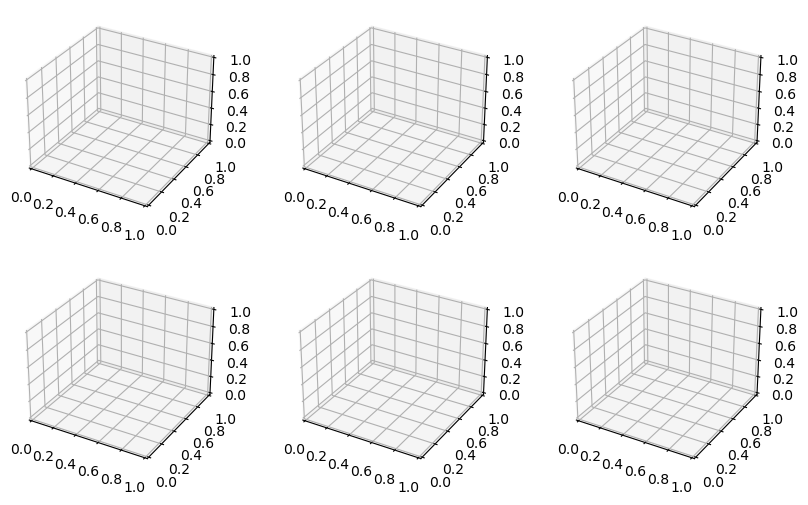

In [85]:
plt.figure(figsize=(10, 6))

index_order = (0,1,2)

#  Creating each subplot in the 5x2 grid
ax1 = plt.subplot(231, projection='3d')  # First row, first column
ax2 = plt.subplot(232, projection='3d')  # First row, second column
ax3 = plt.subplot(233, projection='3d')  # First row, second column
ax4 = plt.subplot(234, projection='3d')  # First row, second column
ax5 = plt.subplot(235, projection='3d')  # First row, second column
ax6 = plt.subplot(236, projection='3d')  # First row, second column

ax1 = cebra.plot_embedding(ax=ax1,idx_order=index_order,embedding=rnn_output_embedding, embedding_labels='time', title='rnn output')
ax2 = cebra.plot_embedding(ax=ax2,idx_order=index_order,embedding=input, embedding_labels='time', title='Mthal rnn Input')
ax3 = cebra.plot_embedding(ax=ax3,idx_order=index_order,embedding=target, embedding_labels='time', title='M1 rnn target')
ax4 = cebra.plot_embedding(ax=ax4,idx_order=index_order,embedding=rnn_output_embedding, embedding_labels=discete_lables[:,0], title='rnn output')
ax5 = cebra.plot_embedding(ax=ax5,idx_order=index_order,embedding=input, embedding_labels=discete_lables[:,0], title='Mthal rnn input')
ax6 = cebra.plot_embedding(ax=ax6,idx_order=index_order,embedding=target, embedding_labels=discete_lables[:,0], title='M1 rnn target')

# add title
plt.suptitle('M1 Vs. Rnn embeddings')

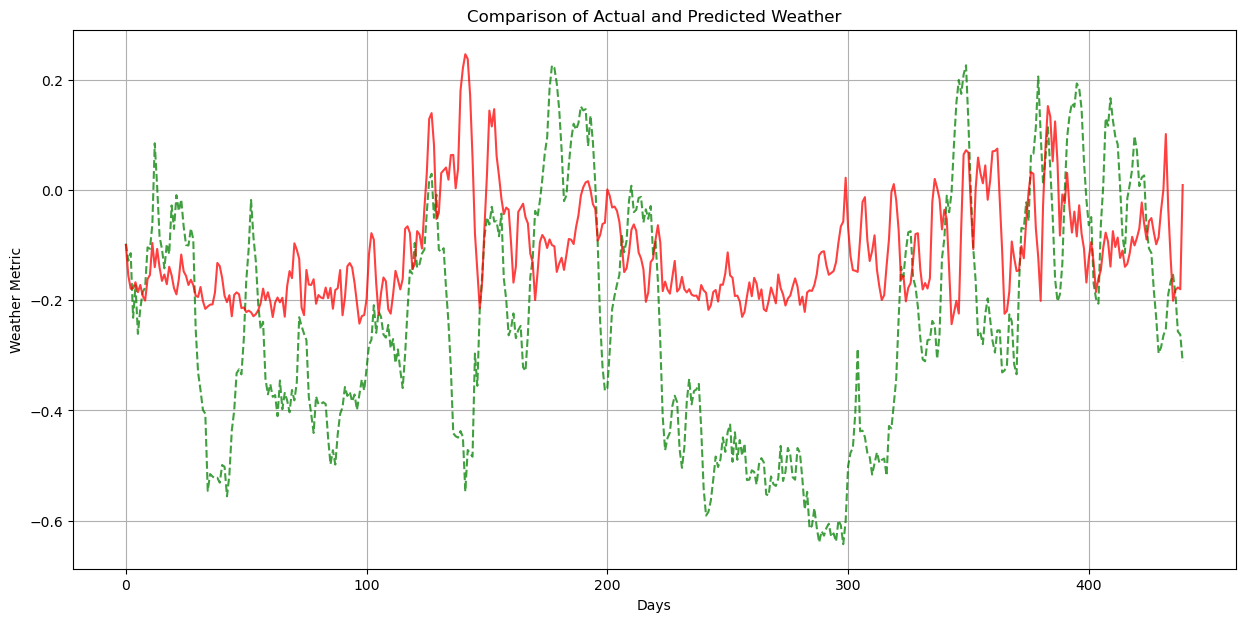

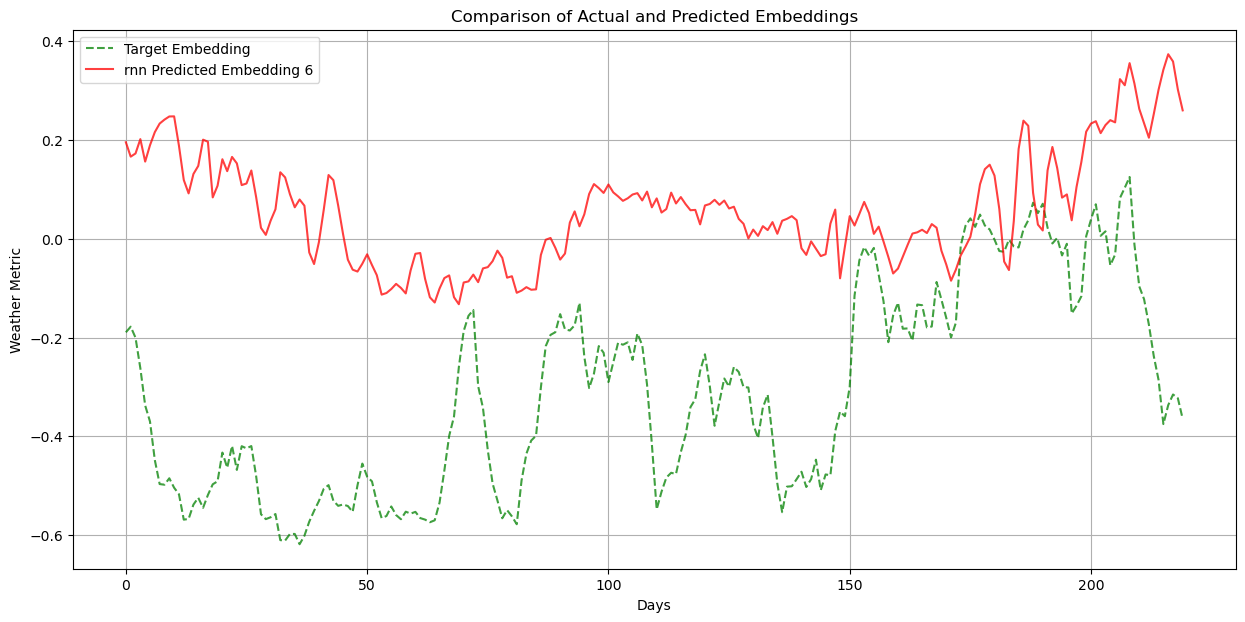

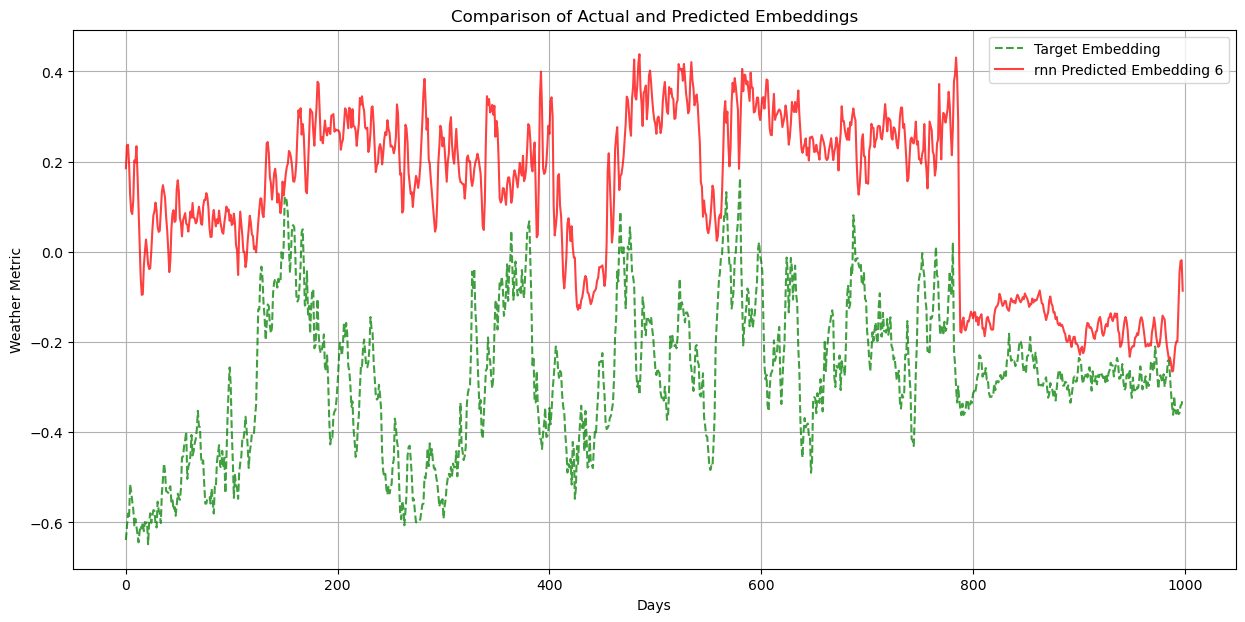

In [86]:
import matplotlib.pyplot as plt

day_start = 0
day_end = 440
plt.figure(figsize=(15, 7))
# plt.plot(targets, label='Actual Weather', color='blue', alpha=0.75)
plt.plot(test_weather_targets_6[day_start:day_end], label='Target Embedding', linestyle='--', color='green', alpha=0.75)
plt.plot(selected_batch_predictions_6[day_start:day_end], label='rnn Predicted Embedding 6', linestyle='-', color='red', alpha=0.75)

plt.title('Comparison of Actual and Predicted Weather')
plt.xlabel('Days')
plt.ylabel('Weather Metric')
# plt.legend()
plt.grid(True)
plt.show()


day_start = 10 *220
day_end = 11*220
plt.figure(figsize=(15, 7))
# plt.plot(targets, label='Actual Weather', color='blue', alpha=0.75)
plt.plot(test_weather_targets_6[day_start:day_end], label='Target Embedding', linestyle='--', color='green', alpha=0.75)
plt.plot(selected_batch_predictions_6[day_start:day_end], label='rnn Predicted Embedding 6', linestyle='-', color='red', alpha=0.75)

plt.title('Comparison of Actual and Predicted Embeddings')
plt.xlabel('Days')
plt.ylabel('Weather Metric')
plt.legend()
plt.grid(True)
plt.show()

day_start = -1000
day_end = -1
plt.figure(figsize=(15, 7))
# plt.plot(targets, label='Actual Weather', color='blue', alpha=0.75)
plt.plot(test_weather_targets_6[day_start:day_end], label='Target Embedding', linestyle='--', color='green', alpha=0.75)
plt.plot(selected_batch_predictions_6[day_start:day_end], label='rnn Predicted Embedding 6', linestyle='-', color='red', alpha=0.75)

plt.title('Comparison of Actual and Predicted Embeddings')
plt.xlabel('Days')
plt.ylabel('Weather Metric')
plt.legend()
plt.grid(True)
plt.show()


addidtional Model Evaluation Adjustments

In [132]:
def calculate_metrics(outputs, targets):
    # You can define any metric here, such as mean squared error
    mse = nn.MSELoss()(outputs, targets)
    return mse.item()

# Adjust the main training loop to include metric calculation
for epoch in range(num_epochs):
    # Existing training and validation loops here

    # Calculate additional metrics or diagnostics
    train_mse = calculate_metrics(all_outputs, torch.cat([y for _, y in train_loader], dim=0))
    val_mse = calculate_metrics(all_val_outputs, torch.cat([y for _, y in val_loader], dim=0))

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {val_loss:.4f} \tTrain MSE: {train_mse:.4f} \tVal MSE: {val_mse:.4f}')

Epoch 1 	Training Loss: 238.7952 	Validation Loss: 289.6269 	Train MSE: 238.7952 	Val MSE: 289.6269
Epoch 101 	Training Loss: 238.7952 	Validation Loss: 289.6269 	Train MSE: 238.7952 	Val MSE: 289.6269
Epoch 201 	Training Loss: 238.7952 	Validation Loss: 289.6269 	Train MSE: 238.7952 	Val MSE: 289.6269
Epoch 301 	Training Loss: 238.7952 	Validation Loss: 289.6269 	Train MSE: 238.7952 	Val MSE: 289.6269
Epoch 401 	Training Loss: 238.7952 	Validation Loss: 289.6269 	Train MSE: 238.7952 	Val MSE: 289.6269
Epoch 501 	Training Loss: 238.7952 	Validation Loss: 289.6269 	Train MSE: 238.7952 	Val MSE: 289.6269
Epoch 601 	Training Loss: 238.7952 	Validation Loss: 289.6269 	Train MSE: 238.7952 	Val MSE: 289.6269
Epoch 701 	Training Loss: 238.7952 	Validation Loss: 289.6269 	Train MSE: 238.7952 	Val MSE: 289.6269
Epoch 801 	Training Loss: 238.7952 	Validation Loss: 289.6269 	Train MSE: 238.7952 	Val MSE: 289.6269
Epoch 901 	Training Loss: 238.7952 	Validation Loss: 289.6269 	Train MSE: 238.7952 	

In [367]:
from datetime import datetime

# Get the current date and time formatted as a string (e.g., "2023-03-28_15-30-45")
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [368]:
rnn_save_path = f'rnn_models/rnn_model_{num_epochs}_{mouse}_{current_datetime}.pth'
# Saving the model
torch.save(neural_rnn.state_dict(), rnn_save_path)

# Loading the model
neural_rnn_loaded = NeuralRNN()  # Ensure it has the same architecture
neural_rnn_loaded.load_state_dict(torch.load(rnn_save_path))
neural_rnn_loaded.eval()  # Set to evaluation mode if inference only

# If you want to continue training, switch back to train mode
neural_rnn_loaded.train()


NeuralRNN(
  (rnn): RNN(3, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [76]:
# # Assuming you have tensors input_tensor and target_tensor prepared
# loss_function = torch.nn.MSELoss()  # Mean Squared Error Loss, or choose another appropriate to your task
# optimizer = torch.optim.Adam(neural_rnn.parameters(), lr=0.0003)  # Using Adam optimizer

# num_epochs = 5000

# # Example training loop
# for epoch in range(num_epochs):
#     optimizer.zero_grad()               # Clear existing gradients
#     output_tensor = neural_rnn(input_tensor)  # Get the model's predictions
#     loss = loss_function(output_tensor, target_tensor)  # Calculate the loss
#     loss.backward()                     # Compute gradient of the loss wrt model parameters
#     optimizer.step()    
#                     # Perform a single optimization step
#     # print every 25 epochs
#     if epoch % 150 == 0:
#         print(f"Epoch {epoch}: Loss = {loss.item()}")


### 4. Visualize Embeddings
- Compare cebra M1 embeddings to RNN predicted embeddings

### 5. Decode lables from embeddings
- Decode lables (trial_ID, Success or Failure) from cebra embeddings
- Decode lables (trial_ID, Success or Failure) from RNN predicted embeddings

### 6. Pass real M1 embeddings cerebellar SNN
- See if SNN can predict when their is an error